# Modelo con shock de Exportaciones + COVID19

El problema se divide en dos partes:

* 1: Debemos estimar los parámetros de la ecuación del modelo de tal manera que ésta nos permita predecir futuros shocks. Lo haremos a partir de las exportaciones.

* 2: Crearemos distintos shocks sobre, en principio, los sectores del **turismo (53)** y la **hostelería (32)**, para comprobar cómo afectaría al resto de la economía a partir de la ecuación de "1".

## I. Creación del modelo via exportaciones

La **ecuación del modelo** será de la forma:

$\nabla \ln Y_{i,t}=\delta_t+\sum_{k=1}^r\phi_k\nabla\ln Y_{i,t-k}+\beta^DD_{i,t}+\beta^UU_{i,t}+\beta^OO_{i,t}+\varepsilon_{i,t}$,

siendo, para cada sector $i\in{1,2,...,64}$ y tiempo $t\in{1,2,...,T}$:

* $Y_{i,t}$: valor añadido **real**.
* $\delta_t$: un conjunto de efectos temporales (basados en _dummies_ en nuestro caso, **por ver**)
* $Y_{i,t-k}$: el retardo k-ésimo del valor añadido hasta un úúltimo retardo significativo $r\in \mathbb{N}_0$
* $D_{i,t}$, $U_{i,t}$, $O_{i,t}$: efectos _downstream_, _upstream_ y propios (_ownshock_), creados como usualmente.
* $\varepsilon_{i,t}$ un error aleatorio que sigue un proceso de ruido blanco.
* $\{\phi_k:k=1,2,...,r\}$, $\beta^U$ ,$\beta^O$, $\beta^D$: parámetros a estimar (via OLS?)$

In [2]:
!pip install linearmodels

In [3]:
import numpy as np
import pandas as pd
import math as mt
from linearmodels import PanelOLS
from linearmodels import PooledOLS
from linearmodels import FirstDifferenceOLS
from linearmodels import BetweenOLS
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
uploaded = files.upload() #cargamos los archivos necersarios

In [0]:
tio=pd.read_csv("tio.csv",delimiter=";")
tio=tio.set_index("Unnamed: 0")

In [5]:
tio

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,total ventas
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871.0,0.1,0.0,0.2,"27,665.3",674.2,3.7,23.8,0.0,0.0,484.8,149.7,199.4,0.0,0.0,0.0,0.2,0.0,9.2,0.0,0.1,7.5,0.0,0.0,0.0,7.1,13.7,0.0,259.9,60.7,0.0,0.0,0.0,9.9,0.0,587.8,0.0,0.0,0.0,0.0,0.5,0.1,1.2,0.0,8.4,0.0,71.3,0.0,7.3,0.0,0.0,0.0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0,0.0,0.0,"31,495.9"
2,10.4,796.7,0.0,1.2,25.7,0.0,72.9,227.0,0.0,0.0,2.8,6.2,36.5,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,20.8,0.0,38.1,0.0,2.7,1.5,0.0,10.4,0.5,0.0,0.0,0.0,0.0,0.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,8.6,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,"1,275.5"
3,0.0,0.0,44.6,0.0,203.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,2.6,0.3,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0,0.0,0.0,297.7
4,0.0,0.0,3.0,53.1,94.0,2.6,0.3,71.3,1.7,"16,960.4",420.0,12.1,2.8,965.5,"2,091.3",102.1,0.3,445.3,22.0,77.8,0.0,7.8,32.3,"5,707.2",7.8,34.7,536.0,0.3,299.2,3.3,0.1,0.0,0.0,3.7,0.0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,57.5,0.2,0.0,3.4,0.1,0.0,2.6,16.6,0.5,0.0,0.0,1.3,3.2,0.0,0.1,0.8,0.0,0.0,"28,121.2"
5,"7,371.8",0.7,164.3,20.5,"23,595.3",194.5,0.1,58.8,0.0,8.8,291.1,285.0,2.0,0.1,0.0,0.2,0.2,1.7,10.6,0.0,0.0,3.9,49.9,461.0,90.7,2.4,79.4,5.6,"1,110.9",606.4,8.6,0.0,0.0,36.9,0.5,"16,639.4",0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,89.2,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0,0.0,0.0,"53,265.7"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,17.3,0.0,2.6,3.9,22.2,2.7,3.8,8.8,4.3,6.3,10.2,2.5,5.2,7.2,0.0,6.2,13.1,4.2,19.1,14.2,2.0,2.0,14.7,26.6,6.9,9.6,26.9,6.7,12.3,10.8,97.5,4.8,11.8,41.6,1.9,108.9,2.4,1.5,19.4,32.4,1.8,0.2,2.9,17.8,246.7,2.0,7.3,3.7,2.3,21.2,0.1,1.7,9.2,209.5,184.4,130.7,6.8,4.8,7.5,0.9,425.6,5.9,0.0,0.0,"1,887.5"
62,0.0,0.0,0.9,1.9,38.5,17.1,3.0,7.8,2.1,20.4,22.3,3.7,11.0,7.8,15.0,15.0,5.0,6.8,12.4,43.5,5.7,11.0,18.6,29.8,3.8,7.8,24.0,34.6,59.2,59.9,31.9,1.1,17.1,19.4,3.2,111.7,7.6,37.7,10.6,21.5,2.7,1.9,1.6,35.7,28.4,16.7,10.3,22.4,12.1,170.3,5.1,20.1,34.9,5.0,6.7,120.1,185.7,7.8,27.4,5.0,3.6,333.1,0.0,0.0,"1,807.0"
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
nominal_vadd_ind=pd.read_csv('nominal_vadd_ind.csv',delimiter=";")
nominal_vadd_ind=nominal_vadd_ind.set_index("indice")


In [7]:
nominal_vadd_ind.head()

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
indice,,,,,,,,,,,,,,,,,,,,,,,
1,29925,28928,27138,23797,24480,22620,22931,23976,22114,23826,23949,21300,22751,23885,24568,23128,22853,21316,19935,20422,19918,19163,15778
2,995,966,968,956,1049,958,1085,981,981,1483,1803,1732,1661,1580,1573,1550,1418,1448,1211,1137,962,847,774
3,1633,1580,1370,1426,1228,1254,1230,1122,1130,970,1222,1177,1267,1421,1386,1474,1509,1500,1595,1517,1460,1461,1340
16,1912,1659,1602,1473,1493,1604,1805,2014,2196,2987,3037,2978,2783,2648,2619,2601,2558,2531,2425,2307,2124,2030,1925
17,3773,3474,3392,3046,3447,3518,3689,3586,3252,3555,3554,3317,3241,3205,3160,3218,3167,2981,2809,2781,2726,2635,2798


Tenemos el vadd en términos nominales (millones de euros). Por ello, cargamos el deflactor del PIB y ajustamos a valor real, para cada industria. [from here](https://www.bde.es/webbde/es/estadis/infoest/indeco.html).

**edit: al final he usado el indice de precios de la industria, better?**

Nota: viene trimestalmente, he hecho una media, desde 1996 a 2019.

In [0]:
deflactor=pd.read_csv("ipreciosindust.csv",delimiter=";") 
deflactor=deflactor.set_index("year")

In [9]:
deflactor.head()

,indice
year,
1975,13.068417
1976,14.779083
1977,17.776083
1978,20.693500
1979,23.690250


Tenemos datos desde 1995 a 2017 del valor añadido y de 1975 a 2020 (ene) del indice de precios de la industria (base 2015?)

In [0]:
real_vadd_ind=nominal_vadd_ind.copy()
for i in real_vadd_ind.columns:
  col=real_vadd_ind[i]
  rcol=col*deflactor["indice"][int(i)]
  real_vadd_ind[i]=rcol

In [11]:
real_vadd_ind.head() # v añadido real

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
indice,,,,,,,,,,,,,,,,,,,,,,,
1,3.025121e+06,2.802224e+06,2.713798e+06,2.429957e+06,2.533580e+06,2326896.780,2.273054e+06,2.222393e+06,1.976936e+06,2205024.822,2.080166e+06,1.785820e+06,1.809874e+06,1.814410e+06,1.804554e+06,1.675018e+06,1.644948e+06,1.508031e+06,1.338291e+06,1.361911e+06,1337015.668,1.273758e+06,1.031497e+06
2,1.005846e+05,9.357537e+04,9.679992e+04,9.761899e+04,1.085672e+05,98548.502,1.075515e+05,9.093126e+04,8.769895e+04,137247.201,1.566053e+05,1.452132e+05,1.321349e+05,1.200238e+05,1.155391e+05,1.122569e+05,1.020669e+05,1.024408e+05,8.129776e+04,7.582473e+04,64575.212,5.629981e+04,5.060077e+04
3,1.650801e+05,1.530529e+05,1.369999e+05,1.456116e+05,1.270930e+05,128997.726,1.219248e+05,1.040009e+05,1.010192e+05,89770.590,1.061407e+05,9.868125e+04,1.007916e+05,1.079454e+05,1.018037e+05,1.067527e+05,1.086171e+05,1.061196e+05,1.070767e+05,1.011663e+05,98003.960,9.711218e+04,8.760339e+04
16,1.932842e+05,1.607055e+05,1.601999e+05,1.504109e+05,1.545194e+05,165001.876,1.789221e+05,1.866825e+05,1.963169e+05,276437.889,2.637883e+05,2.496795e+05,2.213916e+05,2.011538e+05,1.923693e+05,1.883744e+05,1.841236e+05,1.790592e+05,1.627969e+05,1.538502e+05,142575.624,1.349334e+05,1.258482e+05
17,3.814129e+05,3.365226e+05,3.391997e+05,3.110329e+05,3.567504e+05,361893.142,3.656752e+05,3.323950e+05,2.907207e+05,329004.585,3.086939e+05,2.781017e+05,2.578261e+05,2.434660e+05,2.321065e+05,2.330599e+05,2.279591e+05,2.108951e+05,1.885759e+05,1.854605e+05,182985.476,1.751476e+05,1.829211e+05


La TIO y las series de valor añadido (nominal) tienen diferentes índices pero entre los que se puede aplicar una biyección traductora. Cargamos el diccionario con las conversiones y las aplicamos mediante una función que definimos ahora para cambiar el índice de 'nominal_vadd_ind' de acuerdo a 'tio' y no al revés.

In [0]:
indice=pd.read_csv('indice.csv',delimiter=";")
indice=indice.set_index('vad')

In [0]:
indicenom=real_vadd_ind.index
ac=[]
for i in indicenom:
    ac.append(indice['tio'][i])
# lo añadimos
real_vadd_ind['indicetio']=ac
real_vadd_ind=real_vadd_ind.set_index('indicetio').sort_index()

### A. Creation of Input and Output tables

In [14]:
tio

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,total ventas
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,871.0,0.1,0.0,0.2,"27,665.3",674.2,3.7,23.8,0.0,0.0,484.8,149.7,199.4,0.0,0.0,0.0,0.2,0.0,9.2,0.0,0.1,7.5,0.0,0.0,0.0,7.1,13.7,0.0,259.9,60.7,0.0,0.0,0.0,9.9,0.0,587.8,0.0,0.0,0.0,0.0,0.5,0.1,1.2,0.0,8.4,0.0,71.3,0.0,7.3,0.0,0.0,0.0,65.4,92.1,112.5,60.1,20.2,2.3,25.4,0.8,0.0,0.0,0.0,0.0,"31,495.9"
2,10.4,796.7,0.0,1.2,25.7,0.0,72.9,227.0,0.0,0.0,2.8,6.2,36.5,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,20.8,0.0,38.1,0.0,2.7,1.5,0.0,10.4,0.5,0.0,0.0,0.0,0.0,0.0,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,8.6,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,"1,275.5"
3,0.0,0.0,44.6,0.0,203.3,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,2.6,0.3,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,21.3,5.9,9.5,0.3,0.0,0.0,0.0,0.0,0.0,0.0,297.7
4,0.0,0.0,3.0,53.1,94.0,2.6,0.3,71.3,1.7,"16,960.4",420.0,12.1,2.8,965.5,"2,091.3",102.1,0.3,445.3,22.0,77.8,0.0,7.8,32.3,"5,707.2",7.8,34.7,536.0,0.3,299.2,3.3,0.1,0.0,0.0,3.7,0.0,23.1,0.9,0.1,0.1,6.8,0.6,0.2,0.7,4.4,39.3,0.7,57.5,0.2,0.0,3.4,0.1,0.0,2.6,16.6,0.5,0.0,0.0,1.3,3.2,0.0,0.1,0.8,0.0,0.0,"28,121.2"
5,"7,371.8",0.7,164.3,20.5,"23,595.3",194.5,0.1,58.8,0.0,8.8,291.1,285.0,2.0,0.1,0.0,0.2,0.2,1.7,10.6,0.0,0.0,3.9,49.9,461.0,90.7,2.4,79.4,5.6,"1,110.9",606.4,8.6,0.0,0.0,36.9,0.5,"16,639.4",0.4,1.8,3.1,3.5,4.2,0.2,3.8,31.4,34.5,4.8,89.2,1.3,21.9,18.5,0.2,1.1,12.1,312.7,327.2,394.3,382.3,212.6,225.5,11.8,0.0,66.0,0.0,0.0,"53,265.7"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,17.3,0.0,2.6,3.9,22.2,2.7,3.8,8.8,4.3,6.3,10.2,2.5,5.2,7.2,0.0,6.2,13.1,4.2,19.1,14.2,2.0,2.0,14.7,26.6,6.9,9.6,26.9,6.7,12.3,10.8,97.5,4.8,11.8,41.6,1.9,108.9,2.4,1.5,19.4,32.4,1.8,0.2,2.9,17.8,246.7,2.0,7.3,3.7,2.3,21.2,0.1,1.7,9.2,209.5,184.4,130.7,6.8,4.8,7.5,0.9,425.6,5.9,0.0,0.0,"1,887.5"
62,0.0,0.0,0.9,1.9,38.5,17.1,3.0,7.8,2.1,20.4,22.3,3.7,11.0,7.8,15.0,15.0,5.0,6.8,12.4,43.5,5.7,11.0,18.6,29.8,3.8,7.8,24.0,34.6,59.2,59.9,31.9,1.1,17.1,19.4,3.2,111.7,7.6,37.7,10.6,21.5,2.7,1.9,1.6,35.7,28.4,16.7,10.3,22.4,12.1,170.3,5.1,20.1,34.9,5.0,6.7,120.1,185.7,7.8,27.4,5.0,3.6,333.1,0.0,0.0,"1,807.0"
63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
A_in=pd.DataFrame()
for i in tio.index[:-1]:
  A_in[i]=np.zeros(len(tio.index[:-1]))
A_in["ind"]=tio.index[:-1]
A_in=A_in.set_index("ind")
for i in tio.index:
  for j in tio.columns:
        try:
            tio[j][i]=tio[j][i].replace(",","")
        except:
            a=0
for i in A_in.index[:-1]:
  for j in A_in.index[:-1]:
    try:
      sales=float(tio[i][j])/float(tio["total ventas"][i])
    except:
      sales=0
    A_in[j][i]=sales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [16]:
A_in #ahora sí q esta bien bien, voy a hacer A_out por definicion y comparar luego

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.027654,0.000330,0.000000,0.000000,0.234056,0.000248,0.000752,0.000111,0.000000,0.014808,0.070015,0.003947,0.008839,0.000067,0.000000,0.018879,0.000095,0.000765,0.002813,0.000054,0.000000,0.000238,0.007893,0.027677,0.014831,0.000264,0.011640,0.023533,0.062357,0.053324,0.004175,0.000013,0.000003,0.001022,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,0.018091,0.014475,0.002705,0.000000,0.000318,0.000432,0.0,0.000064,0.009198,0.000702,0.000111,0.000000,0.002832,0.000159,0.000206,0.000000,0.000000,0.000032,0.000000,0.000254,0.000549,0.000000,0.0,0.0
2,0.000078,0.624618,0.000000,0.000000,0.000549,0.000000,0.000000,0.000000,0.000000,0.009173,0.004939,0.000000,0.000000,0.000000,0.000000,0.000078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005880,0.002274,0.000000,0.000000,0.000941,0.026029,0.057624,0.001568,0.008232,0.000157,0.000078,0.000078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010506,0.000235,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.149815,0.010077,0.551898,0.136379,0.043332,0.001008,0.000000,0.585489,0.063823,0.009405,0.055089,0.000000,0.006382,0.027880,0.020155,0.025529,0.054081,0.051058,0.026201,0.045684,0.408465,0.063151,0.016795,0.018475,0.007390,0.013100,0.264696,0.209607,0.051394,0.249916,0.024521,0.123950,0.001344,0.017803,0.000000,0.000000,0.032247,0.008734,0.075915,0.054417,0.011421,0.011757,0.023850,0.008398,0.0,0.010077,0.008734,0.078267,0.004703,0.010077,0.018475,0.093719,0.003023,0.007054,0.000000,0.005039,0.002351,0.101780,0.008734,0.003023,0.0,0.0
4,0.000007,0.000043,0.000000,0.001888,0.000729,0.000050,0.001138,0.000124,0.000011,0.002375,0.003389,0.000011,0.000501,0.005931,0.000843,0.001092,0.000068,0.000181,0.003350,0.000036,0.000060,0.000142,0.003126,0.006493,0.000078,0.001234,0.002070,0.001045,0.003563,0.001828,0.008232,0.000167,0.000185,0.003599,0.000043,0.000100,0.000021,0.000000,0.001878,0.000135,0.001124,0.000377,0.000206,0.001447,0.002127,0.001952,0.0,0.000231,0.001671,0.002148,0.000117,0.000018,0.003517,0.000128,0.000156,0.000178,0.000000,0.000004,0.000004,0.000021,0.000139,0.000068,0.0,0.0
5,0.519383,0.000482,0.003817,0.001765,0.442974,0.000462,0.005163,0.033802,0.007817,0.001243,0.017912,0.003252,0.038804,0.019838,0.000854,0.015070,0.000017,0.000285,0.002476,0.000000,0.000019,0.000437,0.009841,0.035355,0.002598,0.005082,0.010590,0.001598,0.135748,0.130300,0.045374,0.000567,0.000407,0.023771,0.000486,0.000302,0.001774,0.006344,0.005394,0.000972,0.016311,0.001998,0.001973,0.005809,0.019348,0.000086,0.0,0.018374,0.002136,0.009021,0.010724,0.000028,0.020940,0.000389,0.002409,0.001795,0.000000,0.000377,0.001187,0.001476,0.000417,0.000723,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.000124,0.000000,0.000000,0.000000,0.001836,0.003657,0.002334,0.001852,0.000000,0.003875,0.003190,0.004435,0.003843,0.002894,0.000000,0.001774,0.007734,0.003003,0.001727,0.000591,0.001618,0.003143,0.000000,0.010628,0.004155,0.003065,0.004466,0.000124,0.010410,0.009259,0.024710,0.000140,0.026935,0.000000,0.000000,0.131487,0.022112,0.000000,0.032786,0.001478,0.032677,0.000903,0.000000,0.000109,0.036723,0.000031,0.0,0.016059,0.007189,0.000591,0.007205,0.000607,0.018502,0.000265,0.050603,0.022485,0.000000,0.000669,0.015498,0.099541,0.000140,0.000778,0.0,0.0
61,0.000000,0.000000,0.000000,0.000053,0.000000,0.007311,0.000212,0.000583,0.002914,0.003762,0.005881,0.00000

In [0]:
A_out=A_in.copy()
for i in A_in.index[:-1]:
  for j in A_in.index[:-1]:
    try:
      sales=float(tio[j][i])/float(tio["total ventas"][i])
    except:
      sales=0
    A_out[j][i]=sales

In [18]:
A_out #bien bien

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.027654,0.000003,0.000000,0.000006,0.878378,0.021406,0.000117,0.000756,0.000000,0.000000,0.015392,0.004753,0.006331,0.000000,0.000000,0.000000,0.000006,0.000000,0.000292,0.000000,0.000003,0.000238,0.000000,0.000000,0.000000,0.000225,0.000435,0.000000,0.008252,0.001927,0.000000,0.000000,0.000000,0.000314,0.000000,0.018663,0.000000,0.000000,0.000000,0.000000,0.000016,0.000003,0.000038,0.000000,0.000267,0.000000,0.002264,0.000000,0.000232,0.000000,0.000000,0.000000,0.002076,0.002924,0.003572,0.001908,0.000641,0.000073,0.000806,0.000025,0.000000,0.000000,0.0,0.0
2,0.008154,0.624618,0.000000,0.000941,0.020149,0.000000,0.057154,0.177969,0.000000,0.000000,0.002195,0.004861,0.028616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.016307,0.000000,0.029871,0.000000,0.002117,0.001176,0.000000,0.008154,0.000392,0.000000,0.000000,0.000000,0.000000,0.000000,0.009486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000627,0.006742,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.149815,0.000000,0.682902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001008,0.000000,0.008734,0.001008,0.000000,0.000000,0.000000,0.000000,0.000000,0.011757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020155,0.071549,0.019819,0.031911,0.001008,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000107,0.001888,0.003343,0.000092,0.000011,0.002535,0.000060,0.603118,0.014935,0.000430,0.000100,0.034334,0.074367,0.003631,0.000011,0.015835,0.000782,0.002767,0.000000,0.000277,0.001149,0.202950,0.000277,0.001234,0.019060,0.000011,0.010640,0.000117,0.000004,0.000000,0.000000,0.000132,0.000000,0.000821,0.000032,0.000004,0.000004,0.000242,0.000021,0.000007,0.000025,0.000156,0.001398,0.000025,0.002045,0.000007,0.000000,0.000121,0.000004,0.000000,0.000092,0.000590,0.000018,0.000000,0.000000,0.000046,0.000114,0.000000,0.000004,0.000028,0.0,0.0
5,0.138397,0.000013,0.003085,0.000385,0.442974,0.003652,0.000002,0.001104,0.000000,0.000165,0.005465,0.005351,0.000038,0.000002,0.000000,0.000004,0.000004,0.000032,0.000199,0.000000,0.000000,0.000073,0.000937,0.008655,0.001703,0.000045,0.001491,0.000105,0.020856,0.011384,0.000161,0.000000,0.000000,0.000693,0.000009,0.312385,0.000008,0.000034,0.000058,0.000066,0.000079,0.000004,0.000071,0.000589,0.000648,0.000090,0.001675,0.000024,0.000411,0.000347,0.000004,0.000021,0.000227,0.005871,0.006143,0.007403,0.007177,0.003991,0.004233,0.000222,0.000000,0.001239,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.001245,0.000000,0.004715,0.000093,0.012231,0.000654,0.001011,0.001634,0.000156,0.005540,0.019964,0.006364,0.001354,0.005866,0.004435,0.008014,0.000622,0.001276,0.002427,0.013180,0.001338,0.005835,0.005244,0.035074,0.000918,0.013195,0.000156,0.016385,0.067144,0.032210,0.030561,0.000903,0.000000,0.004855,0.000016,0.025379,0.002303,0.003719,0.006038,0.074800,0.013600,0.000731,0.005991,0.019046,0.046760,0.033860,0.006831,0.015903,0.015156,0.002925,0.004186,0.000000,0.024944,0.002676,0.011515,0.002676,0.055645,0.126834,0.089582,0.099541,0.003097,0.001649,0.0,0.0
61,0.009166,0.000000,0.001377,0.002066,0.011762,0.001430,0.002013,0.004662,0.00

In [19]:
A_out2=A_in.copy()
for i in A_in.index[:-1]:
  for j in A_in.index[:-1]:
    try:
      sales=A_in[i][j]*float(tio["total ventas"][j])/float(tio["total ventas"][i])
    except:
      sales=0
    A_out2[j][i]=sales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [20]:
A_out2 # coincide !!!! buena señal

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.027654,0.000003,0.000000,0.000006,0.878378,0.021406,0.000117,0.000756,0.000000,0.000000,0.015392,0.004753,0.006331,0.000000,0.000000,0.000000,0.000006,0.000000,0.000292,0.000000,0.000003,0.000238,0.000000,0.000000,0.000000,0.000225,0.000435,0.000000,0.008252,0.001927,0.000000,0.000000,0.000000,0.000314,0.000000,0.018663,0.000000,0.000000,0.000000,0.000000,0.000016,0.000003,0.000038,0.000000,0.000267,0.000000,0.002264,0.000000,0.000232,0.000000,0.000000,0.000000,0.002076,0.002924,0.003572,0.001908,0.000641,0.000073,0.000806,0.000025,0.000000,0.000000,0.0,0.0
2,0.008154,0.624618,0.000000,0.000941,0.020149,0.000000,0.057154,0.177969,0.000000,0.000000,0.002195,0.004861,0.028616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.016307,0.000000,0.029871,0.000000,0.002117,0.001176,0.000000,0.008154,0.000392,0.000000,0.000000,0.000000,0.000000,0.000000,0.009486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000627,0.006742,0.000000,0.000000,0.000000,0.000235,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.149815,0.000000,0.682902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001008,0.000000,0.008734,0.001008,0.000000,0.000000,0.000000,0.000000,0.000000,0.011757,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020155,0.071549,0.019819,0.031911,0.001008,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000107,0.001888,0.003343,0.000092,0.000011,0.002535,0.000060,0.603118,0.014935,0.000430,0.000100,0.034334,0.074367,0.003631,0.000011,0.015835,0.000782,0.002767,0.000000,0.000277,0.001149,0.202950,0.000277,0.001234,0.019060,0.000011,0.010640,0.000117,0.000004,0.000000,0.000000,0.000132,0.000000,0.000821,0.000032,0.000004,0.000004,0.000242,0.000021,0.000007,0.000025,0.000156,0.001398,0.000025,0.002045,0.000007,0.000000,0.000121,0.000004,0.000000,0.000092,0.000590,0.000018,0.000000,0.000000,0.000046,0.000114,0.000000,0.000004,0.000028,0.0,0.0
5,0.138397,0.000013,0.003085,0.000385,0.442974,0.003652,0.000002,0.001104,0.000000,0.000165,0.005465,0.005351,0.000038,0.000002,0.000000,0.000004,0.000004,0.000032,0.000199,0.000000,0.000000,0.000073,0.000937,0.008655,0.001703,0.000045,0.001491,0.000105,0.020856,0.011384,0.000161,0.000000,0.000000,0.000693,0.000009,0.312385,0.000008,0.000034,0.000058,0.000066,0.000079,0.000004,0.000071,0.000589,0.000648,0.000090,0.001675,0.000024,0.000411,0.000347,0.000004,0.000021,0.000227,0.005871,0.006143,0.007403,0.007177,0.003991,0.004233,0.000222,0.000000,0.001239,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.001245,0.000000,0.004715,0.000093,0.012231,0.000654,0.001011,0.001634,0.000156,0.005540,0.019964,0.006364,0.001354,0.005866,0.004435,0.008014,0.000622,0.001276,0.002427,0.013180,0.001338,0.005835,0.005244,0.035074,0.000918,0.013195,0.000156,0.016385,0.067144,0.032210,0.030561,0.000903,0.000000,0.004855,0.000016,0.025379,0.002303,0.003719,0.006038,0.074800,0.013600,0.000731,0.005991,0.019046,0.046760,0.033860,0.006831,0.015903,0.015156,0.002925,0.004186,0.000000,0.024944,0.002676,0.011515,0.002676,0.055645,0.126834,0.089582,0.099541,0.003097,0.001649,0.0,0.0
61,0.009166,0.000000,0.001377,0.002066,0.011762,0.001430,0.002013,0.004662,0.00

In [0]:
A_in=A_in.drop("64",axis=1)
A_in=A_in.drop("63",axis=1)
A_in=A_in.drop("63",axis=0)
A_in=A_in.drop("64",axis=0)
A_out=A_out.drop("64",axis=1)
A_out=A_out.drop("63",axis=1)
A_out=A_out.drop("63",axis=0)
A_out=A_out.drop("64",axis=0)

Ahora tenemos ya A_in y A_out con las que crearemos los efectos Upstream y Downstream a partir de las exportaciones, de las que debemos obtener nuevos datos.

### B. Shock de Exportaciones

Como no existen datos para todos los sectores (solo para algunas ramas de actividad a paritr de la Agencia Tributaria), lo que haremos será crear un Shock tal que:

$Exports_i^{T^*}\%=\dfrac{Sales_{i\rightarrow X}^{T^*}}{\sum_iSales_{i\rightarrow X}^{T^*}}$

Con los valores de $Sales$ tomados de las TIO para $T^*=2016$.
Y, de aquí:

$XShock_{i,t}=Exports_i^{T^*}\%\nabla\ln TotExports_{t}$

Y, con ello, podemos crear la matriz de efectos downstream y upstream:

E.g.:

$Downstream_{i,t}^X=\sum_{j}(Input\%^{T^*}_{j\rightarrow i}-1_{j=i})·XShock_{j,t}$

In [0]:
exports_pc=pd.read_csv("exports_porcentaje.csv",delimiter=";")

In [0]:
exports_pc=exports_pc[0:62]
exports_pc=exports_pc.set_index("ind")

In [24]:
exports_pc # esta es la variable Exports % (T^*), logicamente suma 1

,exp
ind,
1.0,0.034421
2.0,0.000496
3.0,0.001537
4.0,0.005539
5.0,0.069820
...,...
58.0,0.001482
59.0,0.000720
60.0,0.000153


In [0]:
exports_tot=pd.read_csv("exports_tot.csv",delimiter=";")
exports=exports_tot.set_index("year")

In [26]:
exports.head()

,ind
year,
2019,116.336975
2018,113.726725
2017,111.286075
2016,105.371225
2015,100.000000


In [0]:
# para cada t, calculamos ∆ln indt
ln=[]
for i in exports.ind:
  ln.append(mt.log(i))
exports["ln_ind"]=ln

d_ln_ind=[]
siguiente=exports["ln_ind"][2019]
for i in exports.ln_ind[1:]:
  d_ln_ind.append(siguiente-i)
  siguiente=i
d_ln_ind.append(np.nan)
exports["d_ln_ind"]=d_ln_ind

In [0]:
exports=exports.sort_index() # ya tenemos lo que queríamos
exports=exports.drop(1995)

In [29]:
exports.head()

,ind,ln_ind,d_ln_ind
year,,,
1996,43.256775,3.767154,0.095054
1997,49.481850,3.901606,0.134452
1998,53.512925,3.979923,0.078317
1999,57.831925,4.057541,0.077618
2000,63.868525,4.156827,0.099286


In [0]:
#matshock
matshock=pd.DataFrame()
for ind in exports_pc.index:
    ac=[]
    for year in exports.index:
        ac.append(exports["d_ln_ind"][year]*exports_pc["exp"][ind])
    matshock[ind]=ac
matshock["year"]=range(1996,2020)
matshock=matshock.set_index("year")

In [31]:
matshock

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,0.003272,0.000047,0.000146,0.000527,0.006637,0.004394,0.000332,0.001022,0.000019,0.002899,0.005267,0.002412,0.001761,0.001378,0.002934,0.001826,0.001210,0.002198,0.003795,0.013445,0.002199,0.000924,0.000144,0.000193,3.128353e-06,0.000380,0.000412,0.001719,0.008404,0.006108,0.002191,0.000208,0.000928,0.001412,0.000041,0.001959,0.000314,0.000493,0.000504,0.002892,0.000755,0.000314,0.000212,0.000077,0.000970,0.002052,0.000294,0.000413,0.000212,0.000150,0.000088,0.001336,0.000840,0.000108,0.000029,0.000017,0.0,0.000141,0.000068,0.000015,0.0,0.000016
1997,0.004628,0.000067,0.000207,0.000745,0.009387,0.006216,0.000470,0.001446,0.000027,0.004100,0.007449,0.003411,0.002491,0.001950,0.004150,0.002583,0.001711,0.003109,0.005368,0.019018,0.003110,0.001306,0.000203,0.000274,4.425006e-06,0.000537,0.000583,0.002431,0.011887,0.008640,0.003099,0.000295,0.001312,0.001998,0.000058,0.002770,0.000444,0.000697,0.000713,0.004091,0.001067,0.000444,0.000299,0.000109,0.001371,0.002903,0.000416,0.000584,0.000300,0.000213,0.000124,0.001889,0.001188,0.000153,0.000041,0.000024,0.0,0.000199,0.000097,0.000021,0.0,0.000022
1998,0.002696,0.000039,0.000120,0.000434,0.005468,0.003620,0.000274,0.000842,0.000016,0.002388,0.004339,0.001987,0.001451,0.001136,0.002418,0.001504,0.000997,0.001811,0.003127,0.011078,0.001812,0.000761,0.000118,0.000159,2.577531e-06,0.000313,0.000339,0.001416,0.006924,0.005033,0.001805,0.000172,0.000764,0.001164,0.000034,0.001614,0.000259,0.000406,0.000415,0.002383,0.000622,0.000258,0.000174,0.000064,0.000799,0.001691,0.000243,0.000340,0.000175,0.000124,0.000072,0.001101,0.000692,0.000089,0.000024,0.000014,0.0,0.000116,0.000056,0.000012,0.0,0.000013
1999,0.002672,0.000038,0.000119,0.000430,0.005419,0.003588,0.000271,0.000835,0.000015,0.002367,0.004300,0.001969,0.001438,0.001125,0.002396,0.001491,0.000988,0.001795,0.003099,0.010979,0.001795,0.000754,0.000117,0.000158,2.554509e-06,0.000310,0.000336,0.001404,0.006862,0.004988,0.001789,0.000170,0.000758,0.001153,0.000034,0.001599,0.000257,0.000402,0.000411,0.002361,0.000616,0.000256,0.000173,0.000063,0.000792,0.001676,0.000240,0.000337,0.000173,0.000123,0.000072,0.001091,0.000686,0.000088,0.000024,0.000014,0.0,0.000115,0.000056,0.000012,0.0,0.000013
2000,0.003417,0.000049,0.000153,0.000550,0.006932,0.004590,0.000347,0.001068,0.000020,0.003028,0.005501,0.002519,0.001840,0.001440,0.003065,0.001907,0.001264,0.002296,0.003964,0.014044,0.002297,0.000965,0.000150,0.000202,3.267632e-06,0.000397,0.000430,0.001795,0.008778,0.006380,0.002289,0.000217,0.000969,0.001475,0.000043,0.002046,0.000328,0.000514,0.000526,0.003021,0.000788,0.000328,0.000221,0.000081,0.001013,0.002143,0.000307,0.000432,0.000222,0.000157,0.000092,0.001395,0.000877,0.000113,0.000031,0.000018,0.0,0.000147,0.000071,0.000015,0.0,0.000016
2001,0.001331,0.000019,0.000059,0.000214,0.002699,0.001787,0.000135,0.000416,0.000008,0.001179,0.002142,0.000981,0.000716,0.000561,0.001193,0.000743,0.000492,0.000894,0.001544,0.005468,0.000894,0.000376,0.000058,0.000079,1.272339e-06,0.000154,0.000168,0.000699,0.003418,0.002484,0.000891,0.000085,0.000377,0.000574,0.000017,0.000797,0.000128,0.000200,0.000205,0.001176,0.000307,0.000128,0.000086,0.000031,0.000394,0.000835,0.000120,0.000168,0.000086,0.000061,0.000036,0.000543,0.000342,0.000044,0.000012,0.000007,0.0,0.000057,0.000028,0.000006,0.0,0.000006
2002,0.000486,0.000007,0.000022,0.000078,0.000986,0.000653,0.000049,0.000152,0.000003,0.000431,0.000783,0.000358,0.000262,0.000205,0.000436,0.000271,0.000180,0.000327,0.000564,0.001998,0.000327,0.000137,0.000021,0.000029,4.649805e-07,0.000056,0.000061,0.000255,0.001249,0.000908,0.000326,0

In [0]:
#now downstrean and upstream
# necesitamos H=(Id-A)^-1

In [0]:
Id_A=A_in.copy()
for i in Id_A.index:
    for j in Id_A.columns:
        if i!=j:
            Id_A[j][i]=0
        if i==j:
            Id_A[j][i]=1
Id_A2=Id_A-A_in
h_in = pd.DataFrame(np.linalg.pinv(Id_A2.values), Id_A2.columns, Id_A2.index)
Amid=h_in-Id_A
downstream=matshock.copy()

In [0]:
A_n=A_in
Amid=A_n
for i in range(200):
  A_n=A_n.dot(A_n)
  Amid=Amid+A_n
Amid=Amid-Id_A

In [0]:
# downstream shock

In [0]:
def valorprop(industria,anyo):
    valinput=Amid.iloc[industria-1].values
    valshock=matshock.loc[anyo]
    valor=sum(valinput*valshock)
    return valor

In [0]:
downstream=matshock.copy()
for year in downstream.index:
    for ind in downstream.columns:
        downstream[ind][year]=valorprop(int(ind),year)

In [38]:
downstream

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,0.009944,0.006154,0.083206,0.000260,0.022622,0.018946,0.006385,0.007349,0.005364,0.003465,0.005142,0.009988,0.006180,0.006065,0.004622,0.006920,0.001585,0.008417,0.008849,0.053124,0.040770,0.009003,0.013961,0.006380,0.009629,0.010305,0.029635,0.058022,0.003535,0.001924,0.008523,0.023311,0.039789,0.005226,0.003182,0.066620,0.013885,0.013633,0.007510,0.046457,0.003850,0.009698,0.005199,0.003163,0.002850,0.009987,450.735632,0.005944,0.005364,0.009311,0.001221,0.295640,0.002416,0.119346,0.029487,0.062348,0.520223,0.035581,0.014911,0.015422,0.008090,0.019460
1997,0.014066,0.008705,0.117693,0.000367,0.031999,0.026799,0.009031,0.010395,0.007587,0.004901,0.007273,0.014128,0.008741,0.008579,0.006538,0.009789,0.002241,0.011905,0.012517,0.075143,0.057669,0.012734,0.019748,0.009025,0.013620,0.014576,0.041918,0.082071,0.005000,0.002721,0.012055,0.032973,0.056281,0.007393,0.004501,0.094234,0.019640,0.019284,0.010623,0.065712,0.005446,0.013718,0.007353,0.004474,0.004032,0.014127,637.558425,0.008408,0.007587,0.013170,0.001727,0.418178,0.003418,0.168813,0.041708,0.088190,0.735847,0.050328,0.021092,0.021815,0.011443,0.027526
1998,0.008193,0.005071,0.068555,0.000214,0.018639,0.015610,0.005260,0.006055,0.004419,0.002855,0.004236,0.008229,0.005092,0.004997,0.003808,0.005702,0.001306,0.006935,0.007291,0.043770,0.033592,0.007418,0.011503,0.005257,0.007934,0.008491,0.024417,0.047806,0.002912,0.001585,0.007022,0.019207,0.032783,0.004306,0.002622,0.054890,0.011440,0.011233,0.006188,0.038277,0.003172,0.007991,0.004283,0.002606,0.002348,0.008229,371.372797,0.004898,0.004419,0.007671,0.001006,0.243585,0.001991,0.098332,0.024295,0.051370,0.428625,0.029316,0.012286,0.012707,0.006665,0.016034
1999,0.008120,0.005025,0.067943,0.000212,0.018473,0.015471,0.005213,0.006001,0.004380,0.002829,0.004199,0.008156,0.005046,0.004952,0.003774,0.005651,0.001294,0.006873,0.007226,0.043379,0.033292,0.007351,0.011400,0.005210,0.007863,0.008415,0.024199,0.047379,0.002886,0.001571,0.006959,0.019035,0.032490,0.004268,0.002598,0.054400,0.011338,0.011132,0.006133,0.037935,0.003144,0.007919,0.004245,0.002583,0.002328,0.008155,368.055683,0.004854,0.004380,0.007603,0.000997,0.241409,0.001973,0.097454,0.024078,0.050911,0.424797,0.029054,0.012176,0.012593,0.006606,0.015891
2000,0.010387,0.006428,0.086910,0.000271,0.023629,0.019790,0.006669,0.007676,0.005602,0.003619,0.005371,0.010433,0.006455,0.006335,0.004828,0.007228,0.001655,0.008791,0.009243,0.055489,0.042586,0.009404,0.014583,0.006664,0.010058,0.010764,0.030954,0.060605,0.003692,0.002009,0.008902,0.024349,0.041560,0.005459,0.003323,0.069587,0.014503,0.014240,0.007845,0.048525,0.004022,0.010130,0.005430,0.003304,0.002977,0.010432,470.803054,0.006209,0.005602,0.009725,0.001275,0.308802,0.002524,0.124659,0.030799,0.065123,0.543384,0.037165,0.015575,0.016109,0.008450,0.020327
2001,0.004044,0.002503,0.033841,0.000106,0.009201,0.007706,0.002597,0.002989,0.002181,0.001409,0.002091,0.004062,0.002513,0.002467,0.001880,0.002815,0.000644,0.003423,0.003599,0.021606,0.016582,0.003662,0.005678,0.002595,0.003916,0.004191,0.012053,0.023598,0.001438,0.000782,0.003466,0.009481,0.016183,0.002126,0.001294,0.027095,0.005647,0.005545,0.003055,0.018895,0.001566,0.003944,0.002114,0.001286,0.001159,0.004062,183.319613,0.002418,0.002181,0.003787,0.000497,0.120240,0.000983,0.048539,0.011993,0.025357,0.211581,0.014471,0.006065,0.006272,0.003290,0.007915
2002,0.001478,0.000915,0.012367,0.000039,0.003362,0.002816,0.000949,0.001092,0.000797,0.000515,0.000764,0.001485,0.000919,0.000901,0.000687,0.001029,0.000236,0.001251,0.001315,0.007896,0.006060,0.001338,0.002075,0.000948,0.001431,0.001532,0.

In [0]:
#upstream

In [0]:
Id_A=A_out.copy()
for i in Id_A.index:
    for j in Id_A.columns:
        if i!=j:
            Id_A[j][i]=0
        if i==j:
            Id_A[j][i]=1
Id_A2=Id_A-A_out
h_out = pd.DataFrame(np.linalg.pinv(Id_A2.values), Id_A2.columns, Id_A2.index)
Amid=h_out-Id_A
A_n=A_out
Amid=A_n
for i in range(200):
  A_n=A_n.dot(A_n)
  Amid=Amid+A_n
Amid=Amid-Id_A
downstream2=matshock.copy()

In [0]:
def valorprop(industria,anyo):
    valinput=Amid.iloc[industria-1].values
    valshock=matshock.loc[anyo]
    valor=sum(valinput*valshock)
    return valor

In [0]:
downstream2=matshock.copy()
for year in downstream2.index:
    for ind in downstream2.columns:
        downstream2[ind][year]=valorprop(int(ind),year)

In [43]:
upstream=downstream2
upstream

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,0.042442,0.036251,0.043671,0.039164,0.036044,0.039793,0.036965,0.039045,0.040132,0.036563,0.037521,0.036244,0.043471,0.035740,0.043445,0.045238,0.042680,0.038143,0.038546,0.046481,0.036902,0.041534,0.040181,0.039929,0.039377,0.040324,0.032097,0.039619,0.034947,0.037089,0.039971,0.040848,0.036623,0.040524,0.037603,0.035272,0.037286,0.041675,0.037200,0.035918,0.032900,0.027726,0.031404,0.040164,0.038458,0.033521,0.058876,0.040122,0.040252,0.039871,0.043328,0.036003,0.039486,0.039205,0.040523,0.039232,0.036187,0.037810,0.038554,0.039094,0.038005,0.039119
1997,0.060033,0.051276,0.061772,0.055397,0.050983,0.056286,0.052287,0.055228,0.056765,0.051718,0.053073,0.051267,0.061488,0.050554,0.061452,0.063988,0.060370,0.053953,0.054523,0.065747,0.052197,0.058749,0.056835,0.056478,0.055698,0.057038,0.045400,0.056040,0.049432,0.052462,0.056539,0.057779,0.051803,0.057321,0.053189,0.049892,0.052741,0.058949,0.052619,0.050805,0.046537,0.039219,0.044420,0.056812,0.054398,0.047416,0.083279,0.056752,0.056936,0.056397,0.061287,0.050926,0.055852,0.055455,0.057319,0.055493,0.051186,0.053481,0.054534,0.055297,0.053757,0.055334
1998,0.034969,0.029868,0.035982,0.032268,0.029697,0.032786,0.030457,0.032170,0.033065,0.030125,0.030914,0.029862,0.035817,0.029447,0.035795,0.037273,0.035165,0.031427,0.031759,0.038297,0.030405,0.034221,0.033106,0.032898,0.032444,0.033224,0.026445,0.032643,0.028794,0.030559,0.032933,0.033656,0.030175,0.033389,0.030982,0.029062,0.030721,0.034337,0.030650,0.029594,0.027107,0.022845,0.025874,0.033092,0.031686,0.027619,0.048510,0.033057,0.033165,0.032851,0.035699,0.029664,0.032533,0.032302,0.033388,0.032324,0.029815,0.031153,0.031765,0.032210,0.031313,0.032231
1999,0.034656,0.029601,0.035660,0.031980,0.029432,0.032493,0.030185,0.031883,0.032770,0.029856,0.030638,0.029596,0.035497,0.029184,0.035476,0.036940,0.034851,0.031147,0.031476,0.037955,0.030133,0.033915,0.032810,0.032604,0.032154,0.032927,0.026209,0.032351,0.028536,0.030286,0.032639,0.033355,0.029905,0.033091,0.030706,0.028802,0.030447,0.034030,0.030377,0.029329,0.026865,0.022640,0.025643,0.032797,0.031403,0.027373,0.048076,0.032762,0.032869,0.032558,0.035380,0.029399,0.032243,0.032014,0.033090,0.032035,0.029549,0.030874,0.031482,0.031923,0.031033,0.031944
2000,0.044331,0.037865,0.045615,0.040908,0.037648,0.041564,0.038611,0.040783,0.041918,0.038191,0.039191,0.037858,0.045406,0.037332,0.045379,0.047252,0.044580,0.039841,0.040263,0.048551,0.038545,0.043383,0.041970,0.041706,0.041130,0.042119,0.033526,0.041383,0.036503,0.038740,0.041751,0.042667,0.038254,0.042328,0.039278,0.036843,0.038946,0.043530,0.038857,0.037517,0.034365,0.028961,0.032802,0.041952,0.040170,0.035014,0.061497,0.041908,0.042044,0.041646,0.045257,0.037606,0.041244,0.040951,0.042327,0.040978,0.037798,0.039493,0.040270,0.040834,0.039697,0.040861
2001,0.017261,0.014744,0.017762,0.015929,0.014659,0.016184,0.015034,0.015880,0.016322,0.014871,0.015260,0.014741,0.017680,0.014536,0.017669,0.018399,0.017358,0.015513,0.015677,0.018905,0.015009,0.016892,0.016342,0.016239,0.016015,0.016400,0.013054,0.016113,0.014213,0.015085,0.016257,0.016613,0.014895,0.016482,0.015294,0.014346,0.015165,0.016950,0.015130,0.014608,0.013381,0.011277,0.012772,0.016335,0.015641,0.013634,0.023946,0.016318,0.016371,0.016216,0.017622,0.014643,0.016059,0.015945,0.016481,0.015956,0.014718,0.015378,0.015680,0.015900,0.015457,0.015910
2002,0.006308,0.005388,0.006491,0.005821,0.005357,0.005915,0.005494,0.005803,0.005965,0.005435,0.005577,0.005387,0.006461,0.005312,0.006457,0.006724,0.006344,0.005669,0.005729,0.006909,0.005485,0.006173,0.005972,0.005935,0.005853,0.005994,0.004771,0.005

### C. Estimation

Ahora, estimamos las ecuaciones del modelo

In [0]:
yt=real_vadd_ind.transpose()
yt=yt.sort_index()
yt["indice"]=range(1995,2018)
yt=yt.set_index("indice")

In [45]:
yt.head()

indicetio,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
indice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,1.031497e+06,50600.766003,87603.393338,156182.467675,821445.251709,390423.481353,125848.158340,182921.115343,120879.607673,127613.301340,314783.835016,162262.404675,227441.944345,393365.386353,250584.930346,383036.031020,155136.457008,182659.612676,223846.282678,451941.983690,105385.574672,200637.921010,78058.546004,690563.167035,113819.035672,89891.541671,2.583123e+06,558046.690695,9.872379e+05,1.893214e+06,9.695865e+05,50273.887669,125325.153006,241366.961346,79823.689004,2.012917e+06,113361.406006,200768.672344,580732.047030,161216.394008,1.090270e+06,118395.332339,91525.933338,2.811873e+06,345118.144351,159189.748341,168080.839009,185993.771676,78516.175671,105385.574672,97540.494672,113949.787006,327009.084683,1.755402e+06,1.438003e+06,1.169767e+06,247577.649679,237182.918679,189720.184676,112773.025006,28176.912335,302166.331349,294778.881015,0.0
1996,1.273758e+06,56299.807669,97112.183005,144372.116007,855398.140376,425871.154355,134933.423340,175147.571675,141713.329340,130945.243340,327894.865683,170760.573675,256705.852680,392569.851353,241351.359679,445479.706022,186646.824009,210974.722011,265878.666680,512813.478359,117518.370673,232245.015345,90996.973671,739408.572037,127954.108340,103759.149672,2.699200e+06,580014.311362,1.089770e+06,1.978204e+06,9.738471e+05,46528.766669,141048.632674,272924.451347,88936.414004,2.096786e+06,134933.423340,217355.810011,639305.254032,194357.305343,1.125464e+06,151417.900674,104157.967672,3.045972e+06,392569.851353,172222.906342,160391.305675,200671.923677,87075.263338,127222.942006,111203.752339,116521.325673,371631.906352,1.870789e+06,1.579053e+06,1.259401e+06,269866.846680,258168.185346,207518.299344,121772.429339,30908.395002,313005.660349,309881.586016,0.0
1997,1.337016e+06,64575.212000,98003.960000,122639.202000,897206.116000,461491.250000,142575.624000,182985.476000,161035.274000,156940.588000,366709.338000,188422.682000,267698.488000,428196.754000,290521.328000,489281.414000,184529.374000,220441.784000,285688.256000,587486.752000,136064.402000,259509.116000,99883.488000,748589.152000,136534.284000,118208.886000,2.849700e+06,586077.106000,1.203166e+06,2.053183e+06,9.837315e+05,46719.696000,142575.624000,316834.720000,101024.630000,2.253688e+06,154792.556000,226617.376000,725900.564000,230040.802000,1.218471e+06,138279.560000,127673.652000,3.319716e+06,441621.954000,187013.036000,157813.226000,216279.972000,95587.424000,147811.452000,123981.722000,117940.382000,409669.978000,1.969208e+06,1.680634e+06,1.300029e+06,282466.208000,271793.174000,219904.776000,131231.330000,33697.252000,321667.792000,322070.548000,0.0
1998,1.361911e+06,75824.729754,101166.328088,114037.192506,915298.518796,487358.949024,153850.177258,185460.486759,175590.601092,156651.090758,378390.076186,194863.553510,284759.539181,467152.358773,316636.602349,526371.672776,192796.212593,235343.422428,308367.238682,627938.131365,139445.479257,282492.133014,108635.430755,692959.337618,141779.573840,134977.355340,3.104212e+06,577655.065196,1.327700e+06,2.077211e+06,1.012197e+06,47415.464252,143846.914757,368120.060018,109369.003339,2.419656e+06,168788.382592,242212.329345,780387.851872,274022.704097,1.246140e+06,152049.590008,145314.059924,3.561828e+06,484758.100774,208134.548427,154450.373008,228674.580761,104367.372089,176324.173675,138245.087757,122039.802506,448079.471606,2.057004e+06,1.781314e+06,1.359844e+06,298697.418265,291361.692431,237944.270679,138111.710924,36678.629168,332975.264433,344045.541601,0.0
1999,1.338291e+06,81297.760250,107076.736250,114662.737000,970202.503000,499131.996250,162796.918750,188575.894750,190522.744500,114125.675000,411658.023000,210192.640250,301560.313000,511887.218750,363121.044750,584054.925000,200324.126000,2

In [0]:
yt_1=yt.copy()
for i in yt_1.columns:
    ac=[np.nan]
    anterior=yt_1[i][1995]
    for j in yt_1[i][1:]:
        ac.append(anterior)
        anterior=j
    yt_1[i]=ac

Aquí tenemos 𝑌𝑡−1, hacemos lo mismo para hallar 𝑈𝑝𝑠𝑡𝑟𝑒𝑎𝑚𝑡−1 y 𝐷𝑜𝑤𝑛𝑠𝑡𝑟𝑒𝑎𝑚𝑡−1 y 𝑂𝑤𝑛𝑆ℎ𝑜𝑐𝑘𝑡−1

In [47]:
yt_1.head()

indicetio,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
indice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,1.031497e+06,50600.766003,87603.393338,156182.467675,821445.251709,390423.481353,125848.158340,182921.115343,120879.607673,127613.301340,314783.835016,162262.404675,227441.944345,393365.386353,250584.930346,383036.031020,155136.457008,182659.612676,223846.282678,451941.983690,105385.574672,200637.921010,78058.546004,690563.167035,113819.035672,89891.541671,2.583123e+06,558046.690695,9.872379e+05,1.893214e+06,9.695865e+05,50273.887669,125325.153006,241366.961346,79823.689004,2.012917e+06,113361.406006,200768.672344,580732.047030,161216.394008,1.090270e+06,118395.332339,91525.933338,2.811873e+06,345118.144351,159189.748341,168080.839009,185993.771676,78516.175671,105385.574672,97540.494672,113949.787006,327009.084683,1.755402e+06,1.438003e+06,1.169767e+06,247577.649679,237182.918679,189720.184676,112773.025006,28176.912335,302166.331349,294778.881015,0.0
1997,1.273758e+06,56299.807669,97112.183005,144372.116007,855398.140376,425871.154355,134933.423340,175147.571675,141713.329340,130945.243340,327894.865683,170760.573675,256705.852680,392569.851353,241351.359679,445479.706022,186646.824009,210974.722011,265878.666680,512813.478359,117518.370673,232245.015345,90996.973671,739408.572037,127954.108340,103759.149672,2.699200e+06,580014.311362,1.089770e+06,1.978204e+06,9.738471e+05,46528.766669,141048.632674,272924.451347,88936.414004,2.096786e+06,134933.423340,217355.810011,639305.254032,194357.305343,1.125464e+06,151417.900674,104157.967672,3.045972e+06,392569.851353,172222.906342,160391.305675,200671.923677,87075.263338,127222.942006,111203.752339,116521.325673,371631.906352,1.870789e+06,1.579053e+06,1.259401e+06,269866.846680,258168.185346,207518.299344,121772.429339,30908.395002,313005.660349,309881.586016,0.0
1998,1.337016e+06,64575.212000,98003.960000,122639.202000,897206.116000,461491.250000,142575.624000,182985.476000,161035.274000,156940.588000,366709.338000,188422.682000,267698.488000,428196.754000,290521.328000,489281.414000,184529.374000,220441.784000,285688.256000,587486.752000,136064.402000,259509.116000,99883.488000,748589.152000,136534.284000,118208.886000,2.849700e+06,586077.106000,1.203166e+06,2.053183e+06,9.837315e+05,46719.696000,142575.624000,316834.720000,101024.630000,2.253688e+06,154792.556000,226617.376000,725900.564000,230040.802000,1.218471e+06,138279.560000,127673.652000,3.319716e+06,441621.954000,187013.036000,157813.226000,216279.972000,95587.424000,147811.452000,123981.722000,117940.382000,409669.978000,1.969208e+06,1.680634e+06,1.300029e+06,282466.208000,271793.174000,219904.776000,131231.330000,33697.252000,321667.792000,322070.548000,0.0
1999,1.361911e+06,75824.729754,101166.328088,114037.192506,915298.518796,487358.949024,153850.177258,185460.486759,175590.601092,156651.090758,378390.076186,194863.553510,284759.539181,467152.358773,316636.602349,526371.672776,192796.212593,235343.422428,308367.238682,627938.131365,139445.479257,282492.133014,108635.430755,692959.337618,141779.573840,134977.355340,3.104212e+06,577655.065196,1.327700e+06,2.077211e+06,1.012197e+06,47415.464252,143846.914757,368120.060018,109369.003339,2.419656e+06,168788.382592,242212.329345,780387.851872,274022.704097,1.246140e+06,152049.590008,145314.059924,3.561828e+06,484758.100774,208134.548427,154450.373008,228674.580761,104367.372089,176324.173675,138245.087757,122039.802506,448079.471606,2.057004e+06,1.781314e+06,1.359844e+06,298697.418265,291361.692431,237944.270679,138111.710924,36678.629168,332975.264433

In [0]:
downstream_1=downstream.copy()
for i in downstream_1.columns:
    ac=[np.nan]
    anterior=downstream_1[i][1996]
    for j in downstream_1[i][1:]:
        ac.append(anterior)
        anterior=j
    downstream_1[i]=ac

upstream_1=upstream.copy()
for i in upstream_1.columns:
    ac=[np.nan]
    anterior=upstream_1[i][1996]
    for j in upstream_1[i][1:]:
        ac.append(anterior)
        anterior=j
    upstream_1[i]=ac

matshock_1=matshock.copy()
for i in matshock_1.columns:
    ac=[np.nan]
    anterior=matshock_1[i][1996]
    for j in matshock_1[i][1:]:
        ac.append(anterior)
        anterior=j
    matshock_1[i]=ac


In [0]:
matshock_1=matshock_1.drop(1996)
matshock_1=matshock_1.drop(2018)
downstream_1=downstream_1.drop(1996)
upstream_1  =  upstream_1.drop(1996)
yt_1=yt_1.drop(1995)
yt_1=yt_1.drop(1996)

In [0]:
downstream_1=downstream_1.drop(2018)
upstream_1=upstream_1.drop(2018)
yt=yt.drop(1995)
yt=yt.drop(1996)

In [0]:
data=pd.DataFrame()
data["yt"]=[]
data["industry"]=[]
data["year"]=[]

In [0]:
for i in yt.columns:
    for j in yt.index:
        parcial=pd.DataFrame()
        parcial["yt"]=[yt[i][j]]
        parcial["industry"]=[i]
        parcial["year"]=[j]
        data=pd.concat([data,parcial])
data["indice"]=range(0,len(data))
data=data.set_index("indice")
ac=[]

In [53]:
data.head()

,yt,industry,year
indice,,,
0,1.337016e+06,1.0,1997.0
1,1.361911e+06,1.0,1998.0
2,1.338291e+06,1.0,1999.0
3,1.508031e+06,1.0,2000.0
4,1.644948e+06,1.0,2001.0


In [54]:
ac=[]
for i in data["yt"]:
    try:
        ac.append(mt.log(i))
    except:
        ac.append(0)
data["yt"]=ac

for i in data.columns:
    ac=[]
    for j in data[i]:
        ac.append(float(j))
    data[i]=ac

data2=pd.DataFrame()
data2["upstream"]=[]
data2["industry"]=[]
data2["year"]=[]
for i in upstream_1.columns:
    for j in upstream_1.index:
        parcial=pd.DataFrame()
        parcial["upstream"]=[upstream_1[i][j]]
        parcial["industry"]=[i]
        parcial["year"]=[j]
        data2=pd.concat([data2,parcial])
data2["indice"]=range(0,len(data2))
data2=data2.set_index("indice")

data2.head()

,upstream,industry,year
indice,,,
0,0.042442,1.0,1997.0
1,0.060033,1.0,1998.0
2,0.034969,1.0,1999.0
3,0.034656,1.0,2000.0
4,0.044331,1.0,2001.0


In [0]:
for i in data2.columns:
    ac=[]
    for j in data2[i]:
        ac.append(float(j))
    data2[i]=ac
  
data3=pd.DataFrame()
data3["downstream"]=[]
data3["industry"]=[]
data3["year"]=[]
for i in downstream_1.columns:
    for j in downstream_1.index:
        parcial=pd.DataFrame()
        parcial["downstream"]=[downstream_1[i][j]]
        parcial["industry"]=[i]
        parcial["year"]=[j]
        data3=pd.concat([data3,parcial])
data3["indice"]=range(0,len(data3))
data3=data3.set_index("indice")

for i in data3.columns:
    ac=[]
    for j in data3[i]:
        ac.append(float(j))
    data3[i]=ac

data4=pd.DataFrame()
data4["ownshock"]=[]
data4["industry"]=[]
data4["year"]=[]
for i in matshock_1.columns:
    for j in matshock_1.index:
        parcial=pd.DataFrame()
        parcial["ownshock"]=[matshock_1[i][j]]
        parcial["industry"]=[i]
        parcial["year"]=[j]
        data4=pd.concat([data4,parcial])
data4["indice"]=range(0,len(data4))
data4=data4.set_index("indice")

In [56]:
for i in data4.columns:
    ac=[]
    for j in data4[i]:
        ac.append(float(j))
    data4[i]=ac
data4.head()

,ownshock,industry,year
indice,,,
0,0.003272,1.0,1997.0
1,0.004628,1.0,1998.0
2,0.002696,1.0,1999.0
3,0.002672,1.0,2000.0
4,0.003417,1.0,2001.0


In [57]:
data5=pd.DataFrame()
data5["yt_1"]=[]
data5["industry"]=[]
data5["year"]=[]
for i in yt_1.columns:
    for j in yt_1.index:
        parcial=pd.DataFrame()
        parcial["yt_1"]=[yt_1[i][j]]
        parcial["industry"]=[i]
        parcial["year"]=[j]
        data5=pd.concat([data5,parcial])
data5["indice"]=range(0,len(data5))
data5=data5.set_index("indice")
ac=[]
for i in data5["yt_1"]:
    try:
        ac.append(mt.log(i))
    except:
        ac.append(0)
data5["yt_1"]=ac
data2=data2.drop(["year","industry"],axis=1)
data3=data3.drop(["year","industry"],axis=1)
data4=data4.drop(["year","industry"],axis=1)
data5=data5.drop(["year","industry"],axis=1)
data=pd.concat([data,data2,data3,data4,data5],axis=1)
data.head()

,yt,industry,year,upstream,downstream,ownshock,yt_1
indice,,,,,,,
0,14.105951,1.0,1997.0,0.042442,0.009944,0.003272,14.057482
1,14.124399,1.0,1998.0,0.060033,0.014066,0.004628,14.105951
2,14.106904,1.0,1999.0,0.034969,0.008193,0.002696,14.124399
3,14.226315,1.0,2000.0,0.034656,0.008120,0.002672,14.106904
4,14.313219,1.0,2001.0,0.044331,0.010387,0.003417,14.226315


In [0]:
def dif_log(num1,num2):
    res=mt.log(num1)-mt.log(num2)
    return res

In [0]:
data2=data.copy()
for i in ["yt","yt_1"]:
    ac=[0]
    anterior=data2[i][0]
    for j in data2[i][1:]:
        ac.append(j-anterior)
        anterior=j
    data[i]=ac

In [0]:
data=data.dropna()

In [0]:
data=data[data["industry"]!=63]
data=data[data["industry"]!=64]
data=data[data["year"]!=1997]
data=data.set_index(["industry","year"])
data_luego=data.copy()

In [0]:
mod = PanelOLS(data.yt, data[['yt_1','upstream','downstream','ownshock']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [63]:
res

Dep. Variable:,yt,R-squared:,0.1865
Estimator:,PanelOLS,R-squared (Between):,0.7995
No. Observations:,1240,R-squared (Within):,-0.0443
Date:,"Sun, May 03 2020",R-squared (Overall):,0.1865
Time:,18:56:34,Log-likelihood,1055.2
Cov. Estimator:,Clustered,,
,,F-statistic:,70.849
Entities:,62,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(4,1236)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,58.993


In [0]:
mod = PanelOLS(data.yt, data[['yt_1','upstream']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [65]:
res

Dep. Variable:,yt,R-squared:,0.1851
Estimator:,PanelOLS,R-squared (Between):,0.7964
No. Observations:,1240,R-squared (Within):,-0.0451
Date:,"Sun, May 03 2020",R-squared (Overall):,0.1851
Time:,18:56:34,Log-likelihood,1054.1
Cov. Estimator:,Clustered,,
,,F-statistic:,140.61
Entities:,62,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(2,1238)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,110.15


In [0]:
mod = PooledOLS(data.yt, data[['yt_1','upstream','downstream','ownshock']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [67]:
res

Dep. Variable:,yt,R-squared:,0.1865
Estimator:,PooledOLS,R-squared (Between):,0.7995
No. Observations:,1240,R-squared (Within):,-0.0443
Date:,"Sun, May 03 2020",R-squared (Overall):,0.1865
Time:,18:56:34,Log-likelihood,1055.2
Cov. Estimator:,Clustered,,
,,F-statistic:,70.849
Entities:,62,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(4,1236)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,58.993


In [0]:
mod = FirstDifferenceOLS(data.yt, data[['yt_1','upstream','downstream','ownshock']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [69]:
res

Dep. Variable:,yt,R-squared:,0.1576
Estimator:,FirstDifferenceOLS,R-squared (Between):,-0.9010
No. Observations:,1178,R-squared (Within):,-0.2741
Date:,"Sun, May 03 2020",R-squared (Overall):,-0.4456
Time:,18:56:35,Log-likelihood,828.38
Cov. Estimator:,Clustered,,
,,F-statistic:,54.889
Entities:,62,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(4,1174)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,160.53


In [0]:
mod = BetweenOLS(data.yt, data[['yt_1','upstream','downstream','ownshock']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [71]:
res

Dep. Variable:,yt,R-squared:,0.9956
Estimator:,BetweenOLS,R-squared (Between):,0.9956
No. Observations:,62,R-squared (Within):,-0.6118
Date:,"Sun, May 03 2020",R-squared (Overall):,-0.1720
Time:,18:56:35,Log-likelihood,255.03
Cov. Estimator:,Clustered,,
,,F-statistic:,3310.6
Entities:,62,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(4,58)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,1.151e+04


In [72]:
datapor=data.copy()
datapor

yt  upstream  downstream  ownshock      yt_1
industry year                                                      
1.0      1998.0  0.018449  0.060033    0.014066  0.004628  0.048468
         1999.0 -0.017495  0.034969    0.008193  0.002696  0.018449
         2000.0  0.119411  0.034656    0.008120  0.002672 -0.017495
         2001.0  0.086904  0.044331    0.010387  0.003417  0.119411
         2002.0  0.018116  0.017261    0.004044  0.001331  0.086904
...                   ...       ...         ...       ...       ...
62.0     2013.0 -0.039228  0.008799    0.003403  0.000016  0.051375
         2014.0 -0.023633  0.039094    0.015422  0.000015 -0.039228
         2015.0  0.033858  0.055297    0.021815  0.000021 -0.023633
         2016.0 -0.030259  0.032210    0.012707  0.000012  0.033858
         2017.0  0.097430  0.031923    0.012593  0.000012 -0.030259

[1240 rows x 5 columns]

In [0]:
ac=[]
for i,val in zip(range(0,len(data)),data["yt_1"]):
  year=data.index[i][1]
  if year==1998.0:
    ac.append(np.nan)
    anterior=val
  else:
    ac.append(anterior)
    anterior=val
data["yt_2"]=ac
data=data.dropna()

In [0]:
ac=[]
for i,val in zip(range(0,len(data)),data["upstream"]):
  year=data.index[i][1]
  if year==1998.0:
    ac.append(np.nan)
    anterior=val
  else:
    ac.append(anterior)
    anterior=val
data["upstream_2"]=ac
data=data.dropna()

In [75]:
data # ya tenemos la yt_2 y upstream_2, upstream_3 si queremos (es la sguiente celda)

yt  upstream  downstream  ...      yt_1      yt_2  upstream_2
industry year                                    ...                                
1.0      1999.0 -0.017495  0.034969    0.008193  ...  0.018449  0.048468   -0.030259
         2000.0  0.119411  0.034656    0.008120  ... -0.017495  0.018449    0.034969
         2001.0  0.086904  0.044331    0.010387  ...  0.119411 -0.017495    0.034656
         2002.0  0.018116  0.017261    0.004044  ...  0.086904  0.119411    0.044331
         2003.0  0.074490  0.006308    0.001478  ...  0.018116  0.086904    0.017261
...                   ...       ...         ...  ...       ...       ...         ...
62.0     2013.0 -0.039228  0.008799    0.003403  ...  0.051375  0.103610    0.021221
         2014.0 -0.023633  0.039094    0.015422  ... -0.039228  0.051375    0.008799
         2015.0  0.033858  0.055297    0.021815  ... -0.023633 -0.039228    0.039094
         2016.0 -0.030259  0.032210    0.012707  ...  0.033858 -0.023633    0.055297
         2017.0  0.097430  0.031923    0.012593  ... -0.030259  0.033858    0.032210

[1178 rows x 7 columns]

In [0]:
list(data.index)
anys=[]
for i in list(data.index):
  anys.append(i[1])

In [0]:
f=pd.DataFrame(np.array(anys))
f[1]=range(len(f))

In [78]:
f.groupby(0).count()

,1
0,
1999.0,62
2000.0,62
2001.0,62
2002.0,62
2003.0,62
2004.0,62
2005.0,62
2006.0,62
2007.0,62


In [79]:
"""
ac=[]
for i,val in zip(range(0,len(data)),data["upstream_2"]):
  year=data.index[i][1]
  if year==1999.0:
    ac.append(np.nan)
    anterior=val
  else:
    ac.append(anterior)
    anterior=val
data["upstream_3"]=ac
data=data.dropna()
"""

'\nac=[]\nfor i,val in zip(range(0,len(data)),data["upstream_2"]):\n  year=data.index[i][1]\n  if year==1999.0:\n    ac.append(np.nan)\n    anterior=val\n  else:\n    ac.append(anterior)\n    anterior=val\ndata["upstream_3"]=ac\ndata=data.dropna()\n'

A partir de aquí, **ajustamos el modelo** con las variables significativas.

In [0]:
mod = PanelOLS(data.yt, data[['yt_1','upstream','upstream_2','ownshock']])
res = mod.fit(cov_type='clustered', cluster_entity=True)

In [81]:
res

Dep. Variable:,yt,R-squared:,0.1891
Estimator:,PanelOLS,R-squared (Between):,0.8260
No. Observations:,1178,R-squared (Within):,-0.0409
Date:,"Sun, May 03 2020",R-squared (Overall):,0.1891
Time:,18:56:35,Log-likelihood,987.96
Cov. Estimator:,Clustered,,
,,F-statistic:,68.424
Entities:,62,P-value,0.0000
Avg Obs:,19.000,Distribution:,"F(4,1174)"
Min Obs:,19.000,,
Max Obs:,19.000,F-statistic (robust):,71.714


In [82]:
data

yt  upstream  downstream  ...      yt_1      yt_2  upstream_2
industry year                                    ...                                
1.0      1999.0 -0.017495  0.034969    0.008193  ...  0.018449  0.048468   -0.030259
         2000.0  0.119411  0.034656    0.008120  ... -0.017495  0.018449    0.034969
         2001.0  0.086904  0.044331    0.010387  ...  0.119411 -0.017495    0.034656
         2002.0  0.018116  0.017261    0.004044  ...  0.086904  0.119411    0.044331
         2003.0  0.074490  0.006308    0.001478  ...  0.018116  0.086904    0.017261
...                   ...       ...         ...  ...       ...       ...         ...
62.0     2013.0 -0.039228  0.008799    0.003403  ...  0.051375  0.103610    0.021221
         2014.0 -0.023633  0.039094    0.015422  ... -0.039228  0.051375    0.008799
         2015.0  0.033858  0.055297    0.021815  ... -0.023633 -0.039228    0.039094
         2016.0 -0.030259  0.032210    0.012707  ...  0.033858 -0.023633    0.055297
         2017.0  0.097430  0.031923    0.012593  ... -0.030259  0.033858    0.032210

[1178 rows x 7 columns]

In [0]:
# queda bien con upstream y upstream_2

In [0]:
mod = PanelOLS(data.yt, data[['yt_1','upstream','upstream_2']])
res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,yt,R-squared:,0.1878
Estimator:,PanelOLS,R-squared (Between):,0.8234
No. Observations:,1178,R-squared (Within):,-0.0416
Date:,"Tue, Apr 28 2020",R-squared (Overall):,0.1878
Time:,19:31:03,Log-likelihood,987.08
Cov. Estimator:,Clustered,,
,,F-statistic:,90.584
Entities:,62,P-value,0.0000
Avg Obs:,19.000,Distribution:,"F(3,1175)"
Min Obs:,19.000,,
Max Obs:,19.000,F-statistic (robust):,93.357


$\nabla \ln \tilde y_{i,t} = 0.2735*\nabla \ln \tilde y_{i,t-1} + 0.6169*\tilde U_{i,t-1}+0.5992*\tilde U_{i.t-2}+\tilde{\varepsilon}_{i,t}$

Parece que la ecuación que mejor ajusta el modelo es: [falta incorporar u_2]

$\ln\nabla \tilde{y}_{i,t}=0.2930*\tilde{y}_{i,t-1}+1.0362*\tilde{U}_{i,t-1}-2.4433*\tilde{O}_{i,t-1}+\tilde{v}_{i,t}$

A partir de aquí, debemos crear distintos shocks para ver cómo se propaga la caída de dos sectores en concreto (Hostelería y Turismo) a través de la red económica. 

## II. Shocks del Covid-19

El marco será el siguiente para los distintos shocks, que serán:

* A. Caída del 90% del turismo sin recuperación.
* B. Caída del 90% de la hostelería sin recuperación.
* C. Caída del 90% del turismo con recuperación.
* D. Caída del 90% de la hostelería con recuperación.
* E. Caída del 90% del turismo + hostelería sin recuperación.
* F. Caída del 90% del turismo + hostelería con recuperación.

Veremos, así, cuáles serían los sectores más afectados, y las consecuencias para el conjunto de la economía y compararemos entre los distintos escenarios. Para ello, se acompañará de la visualización de los datos.

### A. Caída del 90% del turismo sin recuperación.

**nota: está mal ahora mismo porque como U(t) cuando es U(t-1), pero no es tan importante más que un retraso temporal**

Nos ponemos en 2018 como si fuera la fecha actual, ya que tenemos datos completos hasta 2017 (se podrán buscar más), no es lo verdaderamente importante por el momento y predeciremos los próximos 24 años, i.e., $t=2018,...,2041$. _Esto se debe a que podemos aprovechar la estructura del programa anterior._

Construimos el shock suponiendo que $y_{2018}$ va a ser el 10% de $y_{2017}$. Por ello: 
 
 $\nabla \ln y_{2018} = \ln y_{2018}-\ln y_{2017} = \ln \dfrac{y_{2018}}{y_{2017}}=\ln(0.1)=-2.3025850929940455$

Suponemos que el shock no tiene recuperación (esto es, cae al 10% de actividad "permanentemente"), desde luego que es **irreal**.

In [0]:
shock_t_sr=matshock.copy()

In [0]:
shock_t_sr["year"]=range(2018,2042)
shock_t_sr=shock_t_sr.set_index("year")
for i in shock_t_sr.columns:
  shock_t_sr[i]=np.zeros(len(shock_t_sr))
  if i==36.0:
    shock_t_sr[i][2018]=mt.log(0.1)

In [86]:
shock_t_sr.head()[[32,33,34,35,36,37,38,39]] #shock t=turismo sr=sin recuperacion

,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
year,,,,,,,,
2018,0.0,0.0,0.0,0.0,-2.302585,0.0,0.0,0.0
2019,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Creamos la matriz Upstream desde aquí, ya que ya tenemos la Ownshock

In [87]:
#upstream
Id_A=A_out.copy()
for i in Id_A.index:
    for j in Id_A.columns:
        if i!=j:
            Id_A[j][i]=0
        if i==j:
            Id_A[j][i]=1
Id_A2=Id_A-A_out
h_out = pd.DataFrame(np.linalg.pinv(Id_A2.values), Id_A2.columns, Id_A2.index)
Amid=h_out-Id_A
A_n=A_out
Amid=A_n
for i in range(200):
  A_n=A_n.dot(A_n)
  Amid=Amid+A_n
Amid=Amid-Id_A
downstream2=shock_t_sr.copy() # aqui hay que cambiar variable
def valorprop(industria,anyo):
    valinput=Amid.iloc[industria-1].values
    valshock=shock_t_sr.loc[anyo] # aqui tambien
    valor=sum(valinput*valshock)
    return valor
downstream2=shock_t_sr.copy() # aqui tambien
for year in downstream2.index:
    for ind in downstream2.columns:
        downstream2[ind][year]=valorprop(int(ind),year)
upstream=downstream2
upstream

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,-1.371378,-0.616952,-1.2121,-0.558784,-1.712514,-0.85013,-0.671626,-0.821524,-0.63596,-0.595834,-0.617669,-0.656919,-0.791815,-0.661999,-0.49891,-0.582254,-0.673265,-0.608447,-0.722718,-0.46104,-0.477204,-0.647045,-0.681621,-0.781673,-0.876271,-0.56159,-0.576622,-0.716403,-0.842688,-0.945391,-0.678466,-0.658803,-0.538616,-0.636859,-0.640608,1.660572,-0.595521,-0.733385,-0.712623,-0.551794,-0.627236,-0.499376,-0.537444,-0.937514,-0.702921,-0.542297,0.0,-0.704856,-0.705192,-0.741868,-0.807092,-0.524752,-0.659433,-0.85034,-0.616234,-0.72391,-0.506188,-0.87896,-0.69945,-0.664033,-0.752386,-0.748603
2019,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
2020,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
2021,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
2022,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
2023,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000
2024,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [0]:
# creo un dataframe con la variable ∆ln y(t-1)
ac=[]
for i in data.index:
  if i[1]==2017:
    ac.append(data["yt_1"][i])

In [0]:
yt_1_d_l=pd.DataFrame()
yt_1_d_l["yt_1"]=ac
yt_1_d_l["ind"]=range(1,63)
yt_1_d_l=yt_1_d_l.set_index("ind")

In [0]:
def preds(y1,upm,os,phi,b1,b2):
  prediccion=pd.DataFrame()
  prediccion["year"]=range(2018,2042)
  prediccion=prediccion.set_index("year")
  for i in y1.index:
    ac=[]
    for j in range(2018,2042):
      try:
        y=phi*y1["yt_1"][i]+b1*upm[i][j]+b2*upm[i][j-1]
      except:
        y=phi*y1["yt_1"][i]+b1*upm[i][j]
      ac.append(y)
    prediccion[i]=ac
  return prediccion

In [0]:
real=pd.DataFrame()
real["year"]=range(1998,2018)
real=real.set_index("year")
for i in range(1,63):
  ac=[]
  for y in range(1998,2018):
    index=(i,y)
    ac.append(data_luego["yt"][index])
  real[i]=ac

In [0]:
predicciones=preds(yt_1_d_l,upstream,shock_t_sr,phi=0.27,b1=0.62,b2=0.6)
conjunta=real.append(predicciones)
ac=[]
for i in conjunta.index:
  ac.append(conjunta.sum(axis=1)[i])
conjunta["Total"]=ac

In [115]:
conjunta

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,Total
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998,0.018449,0.160594,0.031758,-0.072722,0.019965,0.054538,0.076107,0.013435,0.086532,-0.001846,0.031356,0.033612,0.061784,0.087073,0.086078,0.073070,0.043825,0.065412,0.076390,0.066588,0.024545,0.084859,0.083993,-0.077219,0.037698,0.132654,0.085546,-0.014474,0.098491,0.011635,0.028525,0.014783,0.008877,0.150029,0.079363,0.071057,0.086560,0.066552,0.072378,0.174954,0.022454,0.094929,0.129420,0.070395,0.093196,0.107006,-0.021539,0.055726,0.087876,0.176387,0.108894,0.034168,0.089619,0.043619,0.058181,0.044983,0.055872,0.069524,0.078842,0.051101,0.084778,0.034549,3.802780
1999,-0.017495,0.069694,0.056780,0.005470,0.058255,0.023870,0.056524,0.016659,0.081616,-0.316721,0.084267,0.075725,0.057325,0.091449,0.136981,0.103987,0.038303,0.045273,0.073353,0.024638,0.101473,0.112072,0.086825,0.008852,0.029887,0.167404,0.125082,0.009638,0.139242,0.041626,0.012553,0.031642,0.039924,0.185636,0.050191,0.098756,0.099757,0.045787,0.036195,0.220739,0.019984,-0.275792,0.083891,0.089913,0.132265,0.134307,0.015667,-0.091649,0.098168,0.187448,0.160585,0.039959,0.106823,0.062745,0.071960,0.066460,0.083949,0.082643,0.073838,0.085531,0.126442,0.039734,3.804108
2000,0.119411,0.231167,-0.008979,0.085257,0.056022,0.070689,0.095213,0.111860,0.234575,0.519857,0.138626,0.167263,0.119581,0.114589,0.245204,0.184768,0.082470,0.136073,0.176867,0.076036,0.027770,0.155493,0.133997,-0.008441,0.102620,0.156612,0.180253,0.020265,0.185829,0.106760,0.055699,0.072797,0.098868,0.219053,0.096958,0.146885,0.235171,0.119745,0.084998,0.255491,0.183589,-0.073897,0.070949,0.186103,0.150472,0.172654,0.068980,0.172926,0.159596,0.230639,0.178906,0.058752,0.163081,0.125438,0.127990,0.133282,0.013664,0.133875,0.146882,0.123889,0.152129,0.085776,8.169046
2001,0.086904,-0.003656,0.023262,0.247536,0.069465,0.085797,0.027891,0.077805,0.029249,0.081864,0.089558,0.127696,0.043981,0.081017,0.049238,0.092423,0.026344,0.066690,0.092280,0.037350,0.084517,0.049154,0.171803,0.044858,0.056702,0.151853,0.139497,0.086169,0.148151,0.078218,0.129782,-0.052290,0.043891,0.152588,0.074779,0.061545,0.038639,0.052303,0.079698,0.226731,0.137863,0.825934,-0.088174,0.096220,0.113679,0.290986,0.018962,0.038725,0.038529,0.105699,0.060780,0.076915,0.155951,0.077649,0.087377,0.078067,0.124143,0.127867,0.097652,0.120977,0.130347,0.034374,6.001804
2002,0.018116,0.095162,-0.017313,0.101792,0.058239,0.011565,0.022824,0.022129,0.062296,-0.032956,0.022444,0.069146,0.045694,0.021644,-0.026414,0.063686,-0.197206,0.038790,0.039724,0.052111,0.220337,0.003180,0.126172,0.087166,0.060531,0.134411,0.106885,0.024295,0.104659,0.069262,0.025966,0.037362,0.054964,0.089594,0.092462,0.061855,0.055126,0.044372,0.099033,0.146781,0.050952,0.260274,-0.072384,0.131153,0.050315,0.062900,0.021167,0.111515,0.012289,0.125226,0.035042,0.092836,0.096875,0.045447,0.060982,0.094471,0.183476,0.098084,0.084011,0.119349,0.101820,0.032696,3.914383
2003,0.074490,0.028818,-0.047469,0.105114,0.093988,0.062336,0.020985,-0.004099,0.023102,0.189921,0.001827,0.081213,0.019529,0.008494,-0.045630,0.059092,-0.031980,0.059253,0.008947,0.067654,0.074793,0.034180,0.095961,0.122521,0.058454,0.059389,0.098223,0.098263,0.086794,0.039189,0.066237,0.012691,0.031405,0.071058,0.065914,0.051081,0.016880,0.053336,0.077557,0.080109,0.049302,-0.008980,0.115985,0.132582,0.053905,0.175376,0.093622,0.113047,0.137632,0.104136,0.073317,0.095527,0.089825,0.077855,0.070498,0.123168,0.178465,0.094598,0.080242,0.099315,0.040975,0.050553,4.110559
2004,0.005447,0.038081,0.058580,0.104275,0.087288,0.007711,0.044653,0.047781,0.051426,0.082173,0.084185,0.109698,0.045582,0.072932,0.075039,0.053093,-0.049993,0.075796,0.082830,0.059429,-0.035510,0.116599,0.127787,0.114782,0.109135,0.077511,0.111985,0.148749,0.116541,0.094789,0.071041,0.051

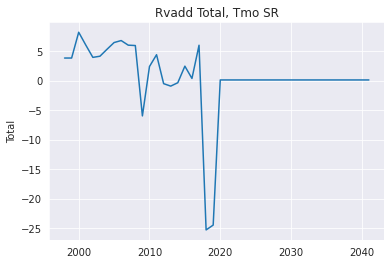

In [116]:
sns.lineplot(range(1998,2042),conjunta["Total"]);
plt.title("Rvadd Total, Tmo SR");

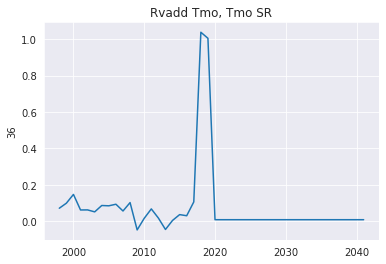

In [117]:
sns.lineplot(range(1998,2042),conjunta[36]);
plt.title("Rvadd Tmo, Tmo SR");

**Esto es un problema, quito el Ownshock del modelo.**

In [0]:
predicciones=preds(yt_1_d_l,upstream,shock_t_sr,phi=0.27,b1=0.62, b2=0.60) # modelo sin ownshock
conjunta=real.append(predicciones)
ac=[]
for i in conjunta.index:
  ac.append(conjunta.sum(axis=1)[i])
conjunta["Total"]=ac

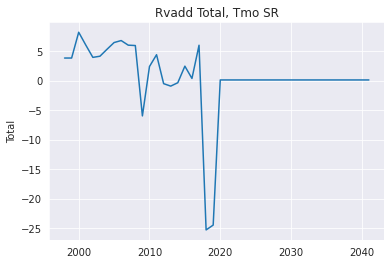

In [119]:
sns.lineplot(range(1998,2042),conjunta["Total"]);
plt.title("Rvadd Total, Tmo SR");

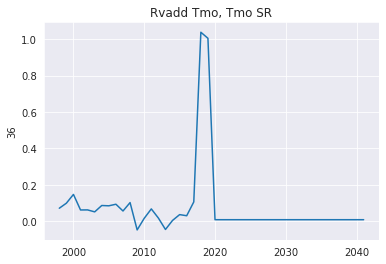

In [120]:
sns.lineplot(range(1998,2042),conjunta[36]);
plt.title("Rvadd Tmo, Tmo SR");

### B. Caída del 90% del turismo y hostelería CON recuperación.

Solo cambio los datos desde la sección anterior.

In [0]:
mt.log(0.1)

-2.3025850929940455

Suponemos que el shock no tiene recuperación (esto es, cae al 10% de actividad "permanentemente"), desde luego que es **irreal**.

In [0]:
shock_t_sr=matshock.copy()

In [0]:
shock_t_sr["year"]=range(2018,2042)
shock_t_sr=shock_t_sr.set_index("year")
for i in shock_t_sr.columns:
  shock_t_sr[i]=np.zeros(len(shock_t_sr))
  if i==36.0:
    shock_t_sr[i][2018]=mt.log(0.1)
  if i==36.0:
    shock_t_sr[i][2019]=mt.log(3)
  if i==36.0:
    shock_t_sr[i][2020]=mt.log(2)
  if i==52.0:
    shock_t_sr[i][2019]=mt.log(0.1)
  if i==52.0:
    shock_t_sr[i][2019]=mt.log(3)
  if i==52.0:
    shock_t_sr[i][2019]=mt.log(2)


In [123]:
shock_t_sr.head()[[32,33,34,35,36,37,38,39]] #shock t=turismo sr=sin recuperacion

,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0
year,,,,,,,,
2018,0.0,0.0,0.0,0.0,-2.302585,0.0,0.0,0.0
2019,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


Creamos la matriz Upstream desde aquí, ya que ya tenemos la Ownshock

In [124]:
#upstream
Id_A=A_out.copy()
for i in Id_A.index:
    for j in Id_A.columns:
        if i!=j:
            Id_A[j][i]=0
        if i==j:
            Id_A[j][i]=1
Id_A2=Id_A-A_out
h_out = pd.DataFrame(np.linalg.pinv(Id_A2.values), Id_A2.columns, Id_A2.index)
Amid=h_out-Id_A
A_n=A_out
Amid=A_n
for i in range(200):
  A_n=A_n.dot(A_n)
  Amid=Amid+A_n
Amid=Amid-Id_A
downstream2=shock_t_sr.copy() # aqui hay que cambiar variable
def valorprop(industria,anyo):
    valinput=Amid.iloc[industria-1].values
    valshock=shock_t_sr.loc[anyo] # aqui tambien
    valor=sum(valinput*valshock)
    return valor
downstream2=shock_t_sr.copy() # aqui tambien
for year in downstream2.index:
    for ind in downstream2.columns:
        downstream2[ind][year]=valorprop(int(ind),year)
upstream=downstream2
upstream

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,-1.371378,-0.616952,-1.212100,-0.558784,-1.712514,-0.850130,-0.671626,-0.821524,-0.635960,-0.595834,-0.617669,-0.656919,-0.791815,-0.661999,-0.498910,-0.582254,-0.673265,-0.608447,-0.722718,-0.461040,-0.477204,-0.647045,-0.681621,-0.781673,-0.876271,-0.561590,-0.576622,-0.716403,-0.842688,-0.945391,-0.678466,-0.658803,-0.538616,-0.636859,-0.640608,1.660572,-0.595521,-0.733385,-0.712623,-0.551794,-0.627236,-0.499376,-0.537444,-0.937514,-0.702921,-0.542297,0.0,-0.704856,-0.705192,-0.741868,-0.807092,-0.524752,-0.659433,-0.850340,-0.616234,-0.723910,-0.506188,-0.878960,-0.699450,-0.664033,-0.752386,-0.748603
2019,0.938289,0.475216,0.847362,0.451240,1.190264,0.625809,0.508729,0.607839,0.502819,0.511464,0.478127,0.501615,0.587563,0.500030,0.397200,0.453321,0.522897,0.471231,0.550075,0.373032,0.424668,0.496533,0.560612,0.597593,0.654521,0.442519,0.445382,0.558530,0.623847,0.689595,0.543788,0.770308,0.958608,0.511767,0.497368,-0.041856,0.477458,0.583530,0.578295,0.472539,0.497649,0.386096,0.422217,0.699180,0.539658,0.439361,0.0,0.562721,0.560749,0.609396,0.617768,0.361194,0.516315,0.657561,0.495208,0.548424,0.403678,0.728630,0.646671,0.526176,0.575600,0.587827
2020,0.412826,0.185721,0.364878,0.168211,0.515518,0.255915,0.202180,0.247303,0.191443,0.179364,0.185937,0.197752,0.238360,0.199282,0.150187,0.175276,0.202673,0.183161,0.217560,0.138787,0.143653,0.194780,0.205188,0.235307,0.263784,0.169056,0.173581,0.215659,0.253674,0.284591,0.204238,0.198319,0.162140,0.191714,0.192842,-0.499882,0.179270,0.220771,0.214521,0.166107,0.188817,0.150327,0.161787,0.282220,0.211600,0.163248,0.0,0.212183,0.212284,0.223325,0.242959,0.157966,0.198509,0.255978,0.185505,0.217919,0.152378,0.264593,0.210555,0.199894,0.226491,0.225352
2021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [0]:
# creo un dataframe con la variable ∆ln y(t-1)
ac=[]
for i in data.index:
  if i[1]==2017:
    ac.append(data["yt_1"][i])

In [0]:
yt_1_d_l=pd.DataFrame()
yt_1_d_l["yt_1"]=ac
yt_1_d_l["ind"]=range(1,63)
yt_1_d_l=yt_1_d_l.set_index("ind")

In [0]:
def preds(y1,upm,os,phi,b1,b2):
  prediccion=pd.DataFrame()
  prediccion["year"]=range(2018,2042)
  prediccion=prediccion.set_index("year")
  for i in y1.index:
    ac=[]
    for j in range(2018,2042):
      try:
        y=phi*y1["yt_1"][i]+b1*upm[i][j]+b2*upm[i][j-1]
      except:
        y=phi*y1["yt_1"][i]+b1*upm[i][j]
      ac.append(y)
    prediccion[i]=ac
  return prediccion

In [0]:
real=pd.DataFrame()
real["year"]=range(1998,2018)
real=real.set_index("year")
for i in range(1,63):
  ac=[]
  for y in range(1998,2018):
    index=(i,y)
    ac.append(data_luego["yt"][index])
  real[i]=ac

In [0]:
predicciones=preds(yt_1_d_l,upstream,shock_t_sr,phi=0.27,b1=0.62,b2=0.60)
conjunta=real.append(predicciones)
ac=[]
for i in conjunta.index:
  ac.append(conjunta.sum(axis=1)[i])
conjunta["Total"]=ac

In [132]:
conjunta

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,Total
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998,0.018449,0.160594,0.031758,-0.072722,0.019965,0.054538,0.076107,0.013435,0.086532,-0.001846,0.031356,0.033612,0.061784,0.087073,0.086078,0.073070,0.043825,0.065412,0.076390,0.066588,0.024545,0.084859,0.083993,-0.077219,0.037698,0.132654,0.085546,-0.014474,0.098491,0.011635,0.028525,0.014783,0.008877,0.150029,0.079363,0.071057,0.086560,0.066552,0.072378,0.174954,0.022454,0.094929,0.129420,0.070395,0.093196,0.107006,-0.021539,0.055726,0.087876,0.176387,0.108894,0.034168,0.089619,0.043619,0.058181,0.044983,0.055872,0.069524,0.078842,0.051101,0.084778,0.034549,3.802780
1999,-0.017495,0.069694,0.056780,0.005470,0.058255,0.023870,0.056524,0.016659,0.081616,-0.316721,0.084267,0.075725,0.057325,0.091449,0.136981,0.103987,0.038303,0.045273,0.073353,0.024638,0.101473,0.112072,0.086825,0.008852,0.029887,0.167404,0.125082,0.009638,0.139242,0.041626,0.012553,0.031642,0.039924,0.185636,0.050191,0.098756,0.099757,0.045787,0.036195,0.220739,0.019984,-0.275792,0.083891,0.089913,0.132265,0.134307,0.015667,-0.091649,0.098168,0.187448,0.160585,0.039959,0.106823,0.062745,0.071960,0.066460,0.083949,0.082643,0.073838,0.085531,0.126442,0.039734,3.804108
2000,0.119411,0.231167,-0.008979,0.085257,0.056022,0.070689,0.095213,0.111860,0.234575,0.519857,0.138626,0.167263,0.119581,0.114589,0.245204,0.184768,0.082470,0.136073,0.176867,0.076036,0.027770,0.155493,0.133997,-0.008441,0.102620,0.156612,0.180253,0.020265,0.185829,0.106760,0.055699,0.072797,0.098868,0.219053,0.096958,0.146885,0.235171,0.119745,0.084998,0.255491,0.183589,-0.073897,0.070949,0.186103,0.150472,0.172654,0.068980,0.172926,0.159596,0.230639,0.178906,0.058752,0.163081,0.125438,0.127990,0.133282,0.013664,0.133875,0.146882,0.123889,0.152129,0.085776,8.169046
2001,0.086904,-0.003656,0.023262,0.247536,0.069465,0.085797,0.027891,0.077805,0.029249,0.081864,0.089558,0.127696,0.043981,0.081017,0.049238,0.092423,0.026344,0.066690,0.092280,0.037350,0.084517,0.049154,0.171803,0.044858,0.056702,0.151853,0.139497,0.086169,0.148151,0.078218,0.129782,-0.052290,0.043891,0.152588,0.074779,0.061545,0.038639,0.052303,0.079698,0.226731,0.137863,0.825934,-0.088174,0.096220,0.113679,0.290986,0.018962,0.038725,0.038529,0.105699,0.060780,0.076915,0.155951,0.077649,0.087377,0.078067,0.124143,0.127867,0.097652,0.120977,0.130347,0.034374,6.001804
2002,0.018116,0.095162,-0.017313,0.101792,0.058239,0.011565,0.022824,0.022129,0.062296,-0.032956,0.022444,0.069146,0.045694,0.021644,-0.026414,0.063686,-0.197206,0.038790,0.039724,0.052111,0.220337,0.003180,0.126172,0.087166,0.060531,0.134411,0.106885,0.024295,0.104659,0.069262,0.025966,0.037362,0.054964,0.089594,0.092462,0.061855,0.055126,0.044372,0.099033,0.146781,0.050952,0.260274,-0.072384,0.131153,0.050315,0.062900,0.021167,0.111515,0.012289,0.125226,0.035042,0.092836,0.096875,0.045447,0.060982,0.094471,0.183476,0.098084,0.084011,0.119349,0.101820,0.032696,3.914383
2003,0.074490,0.028818,-0.047469,0.105114,0.093988,0.062336,0.020985,-0.004099,0.023102,0.189921,0.001827,0.081213,0.019529,0.008494,-0.045630,0.059092,-0.031980,0.059253,0.008947,0.067654,0.074793,0.034180,0.095961,0.122521,0.058454,0.059389,0.098223,0.098263,0.086794,0.039189,0.066237,0.012691,0.031405,0.071058,0.065914,0.051081,0.016880,0.053336,0.077557,0.080109,0.049302,-0.008980,0.115985,0.132582,0.053905,0.175376,0.093622,0.113047,0.137632,0.104136,0.073317,0.095527,0.089825,0.077855,0.070498,0.123168,0.178465,0.094598,0.080242,0.099315,0.040975,0.050553,4.110559
2004,0.005447,0.038081,0.058580,0.104275,0.087288,0.007711,0.044653,0.047781,0.051426,0.082173,0.084185,0.109698,0.045582,0.072932,0.075039,0.053093,-0.049993,0.075796,0.082830,0.059429,-0.035510,0.116599,0.127787,0.114782,0.109135,0.077511,0.111985,0.148749,0.116541,0.094789,0.071041,0.051

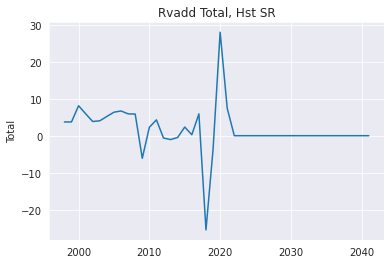

In [133]:
sns.lineplot(range(1998,2042),conjunta["Total"]);
plt.title("Rvadd Total, Hst SR");

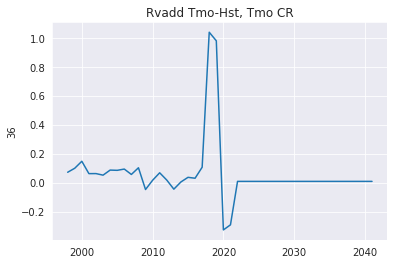

In [134]:
sns.lineplot(range(1998,2042),conjunta[36]);
plt.title("Rvadd Tmo-Hst, Tmo CR");

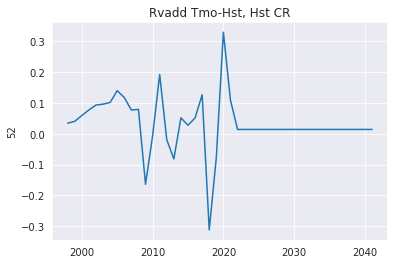

In [135]:
sns.lineplot(range(1998,2042),conjunta[52]);
plt.title("Rvadd Tmo-Hst, Hst CR");

In [136]:
conjunta.transpose()[2018].to_frame().sort_values(2018)

,2018
Total,-25.291063
5,-1.064363
1,-0.841597
3,-0.721585
44,-0.583487
...,...
57,-0.308804
20,-0.282173
42,-0.224658
47,-0.015225


In [0]:
#  3, 51, 10, 42           en contra
# 21, 41, 35, 37, 58       a favor

In [137]:
Amid["36"][1:50]

ind
2     0.267939
3     0.526408
4     0.242677
5     0.743735
6     0.369207
7     0.291683
8     0.356783
9     0.276194
10    0.258768
11    0.268250
12    0.285296
13    0.343881
14    0.287503
15    0.216674
16    0.252870
17    0.292395
18    0.264245
19    0.313873
20    0.200227
21    0.207247
22    0.281008
23    0.296024
24    0.339476
25    0.380560
26    0.243896
27    0.250424
28    0.311130
29    0.365975
30    0.410578
31    0.294654
32    0.286114
33    0.233918
34    0.276584
35    0.278212
36   -0.721177
37    0.258632
38    0.318505
39    0.309488
40    0.239641
41    0.272405
42    0.216876
43    0.233409
44    0.407157
45    0.305275
46    0.235516
47    0.000000
48    0.306115
49    0.306261
50    0.322189
Name: 36, dtype: float64

### C. Mejora de la Predicción

La predicción anterior tiene algunos errores de implementación. Así, con el shock propuesto (una caída TRANSITORIA, pero con recuperación no-completa (90%); para hostelería + turismo); a partir de la ecuación:

$\nabla \ln \tilde y_{i,t} = 0.2735*\nabla \ln \tilde y_{i,t-1} + 0.6169*\tilde U_{i,t-1}+0.5992*\tilde U_{i.t-2}+\tilde{\varepsilon}_{i,t}$

El "problema" es que si meto el shock hoy, me afecta mañana -> debo modificar también la serie $\nabla\ln y_{i,t}$. 

Así, en la predicción de T+1 (2018 en nuestro caso), obligo a que sea ln(0.1) para los sectores afectados (36 Hst, 52 Tmo) y los demás como siempre. A partir de ahí comienza a actuar el efecto red (con su retardo).


In [257]:
data

yt  upstream  downstream  ...      yt_1      yt_2  upstream_2
industry year                                    ...                                
1.0      1999.0 -0.017495  0.034969    0.008193  ...  0.018449  0.048468   -0.030259
         2000.0  0.119411  0.034656    0.008120  ... -0.017495  0.018449    0.034969
         2001.0  0.086904  0.044331    0.010387  ...  0.119411 -0.017495    0.034656
         2002.0  0.018116  0.017261    0.004044  ...  0.086904  0.119411    0.044331
         2003.0  0.074490  0.006308    0.001478  ...  0.018116  0.086904    0.017261
...                   ...       ...         ...  ...       ...       ...         ...
62.0     2013.0 -0.039228  0.008799    0.003403  ...  0.051375  0.103610    0.021221
         2014.0 -0.023633  0.039094    0.015422  ... -0.039228  0.051375    0.008799
         2015.0  0.033858  0.055297    0.021815  ... -0.023633 -0.039228    0.039094
         2016.0 -0.030259  0.032210    0.012707  ...  0.033858 -0.023633    0.055297
         2017.0  0.097430  0.031923    0.012593  ... -0.030259  0.033858    0.032210

[1178 rows x 7 columns]

In [0]:
# ecuacion ∆ln_y = phi*∆ln_y1 + b1*u_1 + b2*u_2
def ecu(y1,u_1,u_2,phi,b1,b2): #prediccion puntual desde T a T+1 para una industria
  ypred= phi*y1+b1*u_1+b2*u_2
  return ypred

In [0]:
# creo la prediccióón para 2018: (a partir de data)

In [0]:
ac=[]
for i in range(1,63):
  if (i!=36)&(i!=52):
    y1=data["yt"][(i,2017)]
    u1=data["upstream"][(i,2017)]
    u2=data["upstream_2"][(i,2017)]
    ac.append(ecu(y1,u1,u2,0.2735,0.6169,0.5992))
  else:
    ac.append(mt.log(0.1))
ac=pd.DataFrame(ac)
ac["industry"]=range(1,63)
ac=ac.set_index("industry")
ac.columns=[2018]
ac=ac.transpose()

In [0]:
data_2018=real.append(ac)

In [262]:
data_2018

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
1998,0.018449,0.160594,0.031758,-0.072722,0.019965,0.054538,0.076107,0.013435,0.086532,-0.001846,0.031356,0.033612,0.061784,0.087073,0.086078,0.073070,0.043825,0.065412,0.076390,0.066588,0.024545,0.084859,0.083993,-0.077219,0.037698,0.132654,0.085546,-0.014474,0.098491,0.011635,0.028525,0.014783,0.008877,0.150029,0.079363,0.071057,0.086560,0.066552,0.072378,0.174954,0.022454,0.094929,0.129420,0.070395,0.093196,0.107006,-0.021539,0.055726,0.087876,0.176387,0.108894,0.034168,0.089619,0.043619,0.058181,0.044983,0.055872,0.069524,0.078842,0.051101,0.084778,0.034549
1999,-0.017495,0.069694,0.056780,0.005470,0.058255,0.023870,0.056524,0.016659,0.081616,-0.316721,0.084267,0.075725,0.057325,0.091449,0.136981,0.103987,0.038303,0.045273,0.073353,0.024638,0.101473,0.112072,0.086825,0.008852,0.029887,0.167404,0.125082,0.009638,0.139242,0.041626,0.012553,0.031642,0.039924,0.185636,0.050191,0.098756,0.099757,0.045787,0.036195,0.220739,0.019984,-0.275792,0.083891,0.089913,0.132265,0.134307,0.015667,-0.091649,0.098168,0.187448,0.160585,0.039959,0.106823,0.062745,0.071960,0.066460,0.083949,0.082643,0.073838,0.085531,0.126442,0.039734
2000,0.119411,0.231167,-0.008979,0.085257,0.056022,0.070689,0.095213,0.111860,0.234575,0.519857,0.138626,0.167263,0.119581,0.114589,0.245204,0.184768,0.082470,0.136073,0.176867,0.076036,0.027770,0.155493,0.133997,-0.008441,0.102620,0.156612,0.180253,0.020265,0.185829,0.106760,0.055699,0.072797,0.098868,0.219053,0.096958,0.146885,0.235171,0.119745,0.084998,0.255491,0.183589,-0.073897,0.070949,0.186103,0.150472,0.172654,0.068980,0.172926,0.159596,0.230639,0.178906,0.058752,0.163081,0.125438,0.127990,0.133282,0.013664,0.133875,0.146882,0.123889,0.152129,0.085776
2001,0.086904,-0.003656,0.023262,0.247536,0.069465,0.085797,0.027891,0.077805,0.029249,0.081864,0.089558,0.127696,0.043981,0.081017,0.049238,0.092423,0.026344,0.066690,0.092280,0.037350,0.084517,0.049154,0.171803,0.044858,0.056702,0.151853,0.139497,0.086169,0.148151,0.078218,0.129782,-0.052290,0.043891,0.152588,0.074779,0.061545,0.038639,0.052303,0.079698,0.226731,0.137863,0.825934,-0.088174,0.096220,0.113679,0.290986,0.018962,0.038725,0.038529,0.105699,0.060780,0.076915,0.155951,0.077649,0.087377,0.078067,0.124143,0.127867,0.097652,0.120977,0.130347,0.034374
2002,0.018116,0.095162,-0.017313,0.101792,0.058239,0.011565,0.022824,0.022129,0.062296,-0.032956,0.022444,0.069146,0.045694,0.021644,-0.026414,0.063686,-0.197206,0.038790,0.039724,0.052111,0.220337,0.003180,0.126172,0.087166,0.060531,0.134411,0.106885,0.024295,0.104659,0.069262,0.025966,0.037362,0.054964,0.089594,0.092462,0.061855,0.055126,0.044372,0.099033,0.146781,0.050952,0.260274,-0.072384,0.131153,0.050315,0.062900,0.021167,0.111515,0.012289,0.125226,0.035042,0.092836,0.096875,0.045447,0.060982,0.094471,0.183476,0.098084,0.084011,0.119349,0.101820,0.032696
2003,0.074490,0.028818,-0.047469,0.105114,0.093988,0.062336,0.020985,-0.004099,0.023102,0.189921,0.001827,0.081213,0.019529,0.008494,-0.045630,0.059092,-0.031980,0.059253,0.008947,0.067654,0.074793,0.034180,0.095961,0.122521,0.058454,0.059389,0.098223,0.098263,0.086794,0.039189,0.066237,0.012691,0.031405,0.071058,0.065914,0.051081,0.016880,0.053336,0.077557,0.080109,0.049302,-0.008980,0.115985,0.132582,0.053905,0.175376,0.093622,0.113047,0.137632,0.104136,0.073317,0.095527,0.089825,0.077855,0.070498,0.123168,0.178465,0.094598,0.080242,0.099315,0.040975,0.050553
2004,0.005447,0.038081,0.058580,0.104275,0.087288,0.007711,0.044653,0.047781,0.051426,0.082173,0.084185,0.109698,0.045582,0.072932,0.075039,0.053093,-0.049993,0.075796,0.082830,0.059429,-0.035510,0.116599,0.127787,0.114782,0.109135,0.077511,0.111985,0.148749,0.116541,0.094789,0.071041,0.051659,0.046819,0.110602,0.088578,0.086049,0.033362,0.059191,0.090763,0.069075,0.074228,0.242257,0.161782,0.164791,0.104542,0.08911

In [0]:
# a partir de aquí ya es "normal", necesito crear upstream a partir de matshock
# personalizado para nuestro interés, con t desde 2017 (T-2 = 2017 si el primer
# periodo de predicción es T=2019)

In [264]:
shock_t_sr

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.302585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.302585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
shock_t_sr=matshock.copy()
shock_t_sr["year"]=range(2017,2041)
shock_t_sr=shock_t_sr.set_index("year")
for i in shock_t_sr.columns:
  shock_t_sr[i]=np.zeros(len(shock_t_sr))
  if i==36.0:
    shock_t_sr[i][2017]=mt.log(0.1)
  if i==36.0:
    shock_t_sr[i][2018]=mt.log(3)
  if i==36.0:
    shock_t_sr[i][2019]=mt.log(2)
  if i==52.0:
    shock_t_sr[i][2017]=mt.log(0.1)
  if i==52.0:
    shock_t_sr[i][2018]=mt.log(3)
  if i==52.0:
    shock_t_sr[i][2019]=mt.log(2)

In [266]:
shock_t_sr.head()[[33,34,35,36,37,38,50,51,52,53,54]] # este es el shock propio
# que no se introduce en el modelo directamente

,33.0,34.0,35.0,36.0,37.0,38.0,50.0,51.0,52.0,53.0,54.0
year,,,,,,,,,,,
2017,0.0,0.0,0.0,-2.302585,0.0,0.0,0.0,0.0,-2.302585,0.0,0.0
2018,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,1.098612,0.0,0.0
2019,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.693147,0.0,0.0
2020,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2021,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [267]:
#upstream
Id_A=A_out.copy()
for i in Id_A.index:
    for j in Id_A.columns:
        if i!=j:
            Id_A[j][i]=0
        if i==j:
            Id_A[j][i]=1
A_n=A_out
Amid=A_n
for i in range(200):
  A_n=A_n.dot(A_n)
  Amid=Amid+A_n
Amid=Amid-Id_A
downstream2=shock_t_sr.copy() # aqui hay que cambiar variable
def valorprop(industria,anyo):
    valinput=Amid.iloc[industria-1].values
    valshock=shock_t_sr.loc[anyo] # aqui tambien
    valor=sum(valinput*valshock)
    return valor
downstream2=shock_t_sr.copy() # aqui tambien
for year in downstream2.index:
    for ind in downstream2.columns:
        downstream2[ind][year]=valorprop(int(ind),year)
upstream=downstream2
upstream.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017,-2.314722,-1.217739,-2.105841,-1.172119,-2.952214,-1.581598,-1.297084,-1.538637,-1.298315,-1.350506,-1.226990,-1.282058,-1.488660,-1.273821,-1.027628,-1.165304,-1.343191,-1.209475,-1.404548,-0.969496,-1.131571,-1.270949,-1.463591,-1.527911,-1.661686,-1.141506,-1.142224,-1.436329,-1.579433,-1.737767,-1.409547,-2.173532,-2.869357,-1.327513,-1.277490,-0.832329,-1.237725,-1.509443,-1.504197,-1.246961,-1.286244,-0.990466,-1.088192,-1.774216,-1.381524,-1.142302,0.0,-1.457004,-1.450258,-1.590406,-1.580063,-0.892901,-1.329419,-1.686953,-1.284572,-1.398363,-1.044886,-1.906297,-1.739043,-1.359483,-1.471985,-1.514815
2018,1.104403,0.581009,1.004742,0.559243,1.408564,0.754614,0.618866,0.734116,0.619454,0.644355,0.585423,0.611697,0.710272,0.607767,0.490303,0.555991,0.640865,0.577066,0.670140,0.462567,0.539897,0.606397,0.698310,0.728999,0.792826,0.544637,0.544979,0.685303,0.753581,0.829125,0.672525,1.037038,1.369031,0.633385,0.609518,0.397122,0.590545,0.720187,0.717684,0.594951,0.613694,0.472573,0.519199,0.846516,0.659154,0.545017,0.0,0.695168,0.691949,0.758816,0.753882,0.426022,0.634294,0.804881,0.612897,0.667189,0.498538,0.909535,0.829735,0.648638,0.702315,0.722750
2019,0.696801,0.366576,0.633921,0.352843,0.888705,0.476108,0.390461,0.463176,0.390832,0.406543,0.369361,0.385938,0.448131,0.383458,0.309347,0.350792,0.404341,0.364088,0.422811,0.291847,0.340637,0.382594,0.440585,0.459947,0.500217,0.343627,0.343844,0.432378,0.475457,0.523120,0.424316,0.654298,0.863762,0.399621,0.384563,0.250556,0.372592,0.454388,0.452808,0.375373,0.387198,0.298160,0.327578,0.534092,0.415880,0.343867,0.0,0.438602,0.436571,0.478760,0.475646,0.268790,0.400195,0.507823,0.386695,0.420949,0.314542,0.573853,0.523504,0.409245,0.443112,0.456005
2020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [0]:
# a partir de data_2018 y upstream, añadimos a pred (copia de data_2018), año a año,
# la predicción

In [0]:
pred=data_2018.copy()
for t in range(2019,2030): # t de la pred
  ac=[]
  for i in range(1,63):
    if (i==36)&(t==2019):
      ac.append(mt.log(3))
    elif (i==52)&(t==2019):
      ac.append(mt.log(3))
    elif (i==36)&(t==2020):
      ac.append(mt.log(2))
    elif (i==52)&(t==2020):
      ac.append(mt.log(2))
    else:
      y1=pred[i][t-1]
      u1=upstream[i][t-1]
      u2=upstream[i][t-2]
      ac.append(ecu(y1,u1,u2,0.2735,0.6169,0.5992))
  dfac=pd.DataFrame(ac)
  dfac["industry"]=range(1,63)
  dfac=dfac.set_index("industry")
  dfac.columns=[t]
  dfac=dfac.transpose()
  pred=pred.append(dfac)

In [0]:
# añado la columna suma (total economia)
pred["Total"]=pred.sum(axis=1)

In [271]:
pred

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,Total
1998,0.018449,0.160594,0.031758,-0.072722,0.019965,0.054538,0.076107,0.013435,0.086532,-0.001846,0.031356,0.033612,0.061784,0.087073,0.086078,0.073070,0.043825,0.065412,0.076390,0.066588,0.024545,0.084859,0.083993,-0.077219,0.037698,0.132654,0.085546,-0.014474,0.098491,0.011635,0.028525,0.014783,0.008877,0.150029,0.079363,0.071057,0.086560,0.066552,0.072378,0.174954,0.022454,0.094929,0.129420,0.070395,0.093196,0.107006,-2.153939e-02,0.055726,0.087876,0.176387,0.108894,0.034168,0.089619,0.043619,0.058181,0.044983,0.055872,0.069524,0.078842,0.051101,0.084778,0.034549,3.802780
1999,-0.017495,0.069694,0.056780,0.005470,0.058255,0.023870,0.056524,0.016659,0.081616,-0.316721,0.084267,0.075725,0.057325,0.091449,0.136981,0.103987,0.038303,0.045273,0.073353,0.024638,0.101473,0.112072,0.086825,0.008852,0.029887,0.167404,0.125082,0.009638,0.139242,0.041626,0.012553,0.031642,0.039924,0.185636,0.050191,0.098756,0.099757,0.045787,0.036195,0.220739,0.019984,-0.275792,0.083891,0.089913,0.132265,0.134307,1.566722e-02,-0.091649,0.098168,0.187448,0.160585,0.039959,0.106823,0.062745,0.071960,0.066460,0.083949,0.082643,0.073838,0.085531,0.126442,0.039734,3.804108
2000,0.119411,0.231167,-0.008979,0.085257,0.056022,0.070689,0.095213,0.111860,0.234575,0.519857,0.138626,0.167263,0.119581,0.114589,0.245204,0.184768,0.082470,0.136073,0.176867,0.076036,0.027770,0.155493,0.133997,-0.008441,0.102620,0.156612,0.180253,0.020265,0.185829,0.106760,0.055699,0.072797,0.098868,0.219053,0.096958,0.146885,0.235171,0.119745,0.084998,0.255491,0.183589,-0.073897,0.070949,0.186103,0.150472,0.172654,6.898023e-02,0.172926,0.159596,0.230639,0.178906,0.058752,0.163081,0.125438,0.127990,0.133282,0.013664,0.133875,0.146882,0.123889,0.152129,0.085776,8.169046
2001,0.086904,-0.003656,0.023262,0.247536,0.069465,0.085797,0.027891,0.077805,0.029249,0.081864,0.089558,0.127696,0.043981,0.081017,0.049238,0.092423,0.026344,0.066690,0.092280,0.037350,0.084517,0.049154,0.171803,0.044858,0.056702,0.151853,0.139497,0.086169,0.148151,0.078218,0.129782,-0.052290,0.043891,0.152588,0.074779,0.061545,0.038639,0.052303,0.079698,0.226731,0.137863,0.825934,-0.088174,0.096220,0.113679,0.290986,1.896155e-02,0.038725,0.038529,0.105699,0.060780,0.076915,0.155951,0.077649,0.087377,0.078067,0.124143,0.127867,0.097652,0.120977,0.130347,0.034374,6.001804
2002,0.018116,0.095162,-0.017313,0.101792,0.058239,0.011565,0.022824,0.022129,0.062296,-0.032956,0.022444,0.069146,0.045694,0.021644,-0.026414,0.063686,-0.197206,0.038790,0.039724,0.052111,0.220337,0.003180,0.126172,0.087166,0.060531,0.134411,0.106885,0.024295,0.104659,0.069262,0.025966,0.037362,0.054964,0.089594,0.092462,0.061855,0.055126,0.044372,0.099033,0.146781,0.050952,0.260274,-0.072384,0.131153,0.050315,0.062900,2.116687e-02,0.111515,0.012289,0.125226,0.035042,0.092836,0.096875,0.045447,0.060982,0.094471,0.183476,0.098084,0.084011,0.119349,0.101820,0.032696,3.914383
2003,0.074490,0.028818,-0.047469,0.105114,0.093988,0.062336,0.020985,-0.004099,0.023102,0.189921,0.001827,0.081213,0.019529,0.008494,-0.045630,0.059092,-0.031980,0.059253,0.008947,0.067654,0.074793,0.034180,0.095961,0.122521,0.058454,0.059389,0.098223,0.098263,0.086794,0.039189,0.066237,0.012691,0.031405,0.071058,0.065914,0.051081,0.016880,0.053336,0.077557,0.080109,0.049302,-0.008980,0.115985,0.132582,0.053905,0.175376,9.362191e-02,0.113047,0.137632,0.104136,0.073317,0.095527,0.089825,0.077855,0.070498,0.123168,0.178465,0.094598,0.080242,0.099315,0.040975,0.050553,4.110559
2004,0.005447,0.038081,0.058580,0.104275,0.087288,0.007711,0.044653,0.047781,0.051426,0.082173,0.084185,0.109698,0.045582,0.072932,0.075039,0.053093,-0.049993,0.075796,0.082830,0.059429,-0.035510,0.116599,0.127787,0.114782,0.109135,0.077511,0.111985,0.148749,0.116541,0.094789,0.071041,0.051659,0.046819,0.110602,0.088578,0.086049,0.03

In [0]:
# pinto algunas 

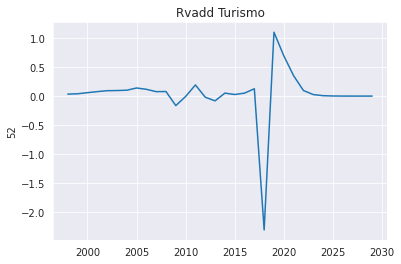

In [399]:
sns.lineplot(range(1998,2030),pred[52]);
plt.title("Rvadd Turismo");
plt.savefig("rvadd_tur.eps",format="eps")

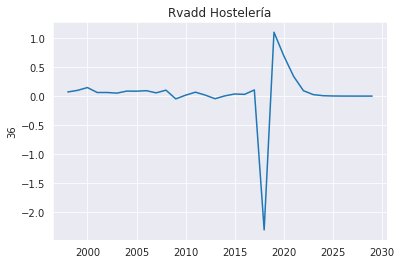

In [400]:
sns.lineplot(range(1998,2030),pred[36]);
plt.title("Rvadd Hostelería");
plt.savefig("rvadd_host.eps",format="eps")

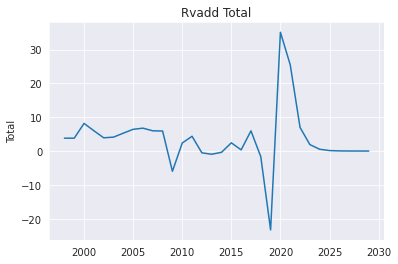

In [275]:
sns.lineplot(range(1998,2030),pred["Total"]);
plt.title("Rvadd Total");
plt.savefig("rvadd_tot.eps",format="eps")

Qué sectores, en teoría, se ven más y menos afectados a c/p ({2019, 2019+2020}) y a l/p (2019+....+2030)???

In [276]:
pred

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,Total
1998,0.018449,0.160594,0.031758,-0.072722,0.019965,0.054538,0.076107,0.013435,0.086532,-0.001846,0.031356,0.033612,0.061784,0.087073,0.086078,0.073070,0.043825,0.065412,0.076390,0.066588,0.024545,0.084859,0.083993,-0.077219,0.037698,0.132654,0.085546,-0.014474,0.098491,0.011635,0.028525,0.014783,0.008877,0.150029,0.079363,0.071057,0.086560,0.066552,0.072378,0.174954,0.022454,0.094929,0.129420,0.070395,0.093196,0.107006,-2.153939e-02,0.055726,0.087876,0.176387,0.108894,0.034168,0.089619,0.043619,0.058181,0.044983,0.055872,0.069524,0.078842,0.051101,0.084778,0.034549,3.802780
1999,-0.017495,0.069694,0.056780,0.005470,0.058255,0.023870,0.056524,0.016659,0.081616,-0.316721,0.084267,0.075725,0.057325,0.091449,0.136981,0.103987,0.038303,0.045273,0.073353,0.024638,0.101473,0.112072,0.086825,0.008852,0.029887,0.167404,0.125082,0.009638,0.139242,0.041626,0.012553,0.031642,0.039924,0.185636,0.050191,0.098756,0.099757,0.045787,0.036195,0.220739,0.019984,-0.275792,0.083891,0.089913,0.132265,0.134307,1.566722e-02,-0.091649,0.098168,0.187448,0.160585,0.039959,0.106823,0.062745,0.071960,0.066460,0.083949,0.082643,0.073838,0.085531,0.126442,0.039734,3.804108
2000,0.119411,0.231167,-0.008979,0.085257,0.056022,0.070689,0.095213,0.111860,0.234575,0.519857,0.138626,0.167263,0.119581,0.114589,0.245204,0.184768,0.082470,0.136073,0.176867,0.076036,0.027770,0.155493,0.133997,-0.008441,0.102620,0.156612,0.180253,0.020265,0.185829,0.106760,0.055699,0.072797,0.098868,0.219053,0.096958,0.146885,0.235171,0.119745,0.084998,0.255491,0.183589,-0.073897,0.070949,0.186103,0.150472,0.172654,6.898023e-02,0.172926,0.159596,0.230639,0.178906,0.058752,0.163081,0.125438,0.127990,0.133282,0.013664,0.133875,0.146882,0.123889,0.152129,0.085776,8.169046
2001,0.086904,-0.003656,0.023262,0.247536,0.069465,0.085797,0.027891,0.077805,0.029249,0.081864,0.089558,0.127696,0.043981,0.081017,0.049238,0.092423,0.026344,0.066690,0.092280,0.037350,0.084517,0.049154,0.171803,0.044858,0.056702,0.151853,0.139497,0.086169,0.148151,0.078218,0.129782,-0.052290,0.043891,0.152588,0.074779,0.061545,0.038639,0.052303,0.079698,0.226731,0.137863,0.825934,-0.088174,0.096220,0.113679,0.290986,1.896155e-02,0.038725,0.038529,0.105699,0.060780,0.076915,0.155951,0.077649,0.087377,0.078067,0.124143,0.127867,0.097652,0.120977,0.130347,0.034374,6.001804
2002,0.018116,0.095162,-0.017313,0.101792,0.058239,0.011565,0.022824,0.022129,0.062296,-0.032956,0.022444,0.069146,0.045694,0.021644,-0.026414,0.063686,-0.197206,0.038790,0.039724,0.052111,0.220337,0.003180,0.126172,0.087166,0.060531,0.134411,0.106885,0.024295,0.104659,0.069262,0.025966,0.037362,0.054964,0.089594,0.092462,0.061855,0.055126,0.044372,0.099033,0.146781,0.050952,0.260274,-0.072384,0.131153,0.050315,0.062900,2.116687e-02,0.111515,0.012289,0.125226,0.035042,0.092836,0.096875,0.045447,0.060982,0.094471,0.183476,0.098084,0.084011,0.119349,0.101820,0.032696,3.914383
2003,0.074490,0.028818,-0.047469,0.105114,0.093988,0.062336,0.020985,-0.004099,0.023102,0.189921,0.001827,0.081213,0.019529,0.008494,-0.045630,0.059092,-0.031980,0.059253,0.008947,0.067654,0.074793,0.034180,0.095961,0.122521,0.058454,0.059389,0.098223,0.098263,0.086794,0.039189,0.066237,0.012691,0.031405,0.071058,0.065914,0.051081,0.016880,0.053336,0.077557,0.080109,0.049302,-0.008980,0.115985,0.132582,0.053905,0.175376,9.362191e-02,0.113047,0.137632,0.104136,0.073317,0.095527,0.089825,0.077855,0.070498,0.123168,0.178465,0.094598,0.080242,0.099315,0.040975,0.050553,4.110559
2004,0.005447,0.038081,0.058580,0.104275,0.087288,0.007711,0.044653,0.047781,0.051426,0.082173,0.084185,0.109698,0.045582,0.072932,0.075039,0.053093,-0.049993,0.075796,0.082830,0.059429,-0.035510,0.116599,0.127787,0.114782,0.109135,0.077511,0.111985,0.148749,0.116541,0.094789,0.071041,0.051659,0.046819,0.110602,0.088578,0.086049,0.03

In [0]:
# algunas métricas
met=pd.DataFrame()
met["ind"]=range(1,64)
met=met.set_index("ind")
ac=[]
ac1=[]
ac2=[]
ac3=[]
ac4=[]
for i in pred.columns:
  ac.append(mt.exp(pred[i][2019]))
  ac1.append(mt.exp(pred[i][2020]))
  ac2.append(mt.exp(pred[i][2019])*mt.exp(pred[i][2020]))
  ac3.append(mt.exp(pred[i][2019])*mt.exp(pred[i][2020])*mt.exp(pred[i][2021])*mt.exp(pred[i][2022])*mt.exp(pred[i][2023]))
  ac4.append(mt.exp(pred[i][2018])*mt.exp(pred[i][2019])*mt.exp(pred[i][2020])*mt.exp(pred[i][2021])*mt.exp(pred[i][2022])*mt.exp(pred[i][2023]))
met["2019"]=ac
met["2020"]=ac1
met["2019-2020"]=ac2
met["2019-2023"]=ac3
met["2018-2023"]=ac4

In [434]:
met

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
1,5.001154e-01,2.464779e+00,1.232674,3.018599e+00,3.162753e+00
2,6.974283e-01,1.609179e+00,1.122287,1.798502e+00,1.871551e+00
3,5.327631e-01,2.272522e+00,1.210716,2.734834e+00,2.860808e+00
4,7.218767e-01,1.589840e+00,1.147668,1.810793e+00,2.031358e+00
5,4.115496e-01,3.156404e+00,1.299017,4.069257e+00,4.254849e+00
...,...,...,...,...,...
59,5.938558e-01,1.969148e+00,1.169390,2.291703e+00,2.368827e+00
60,6.704172e-01,1.701937e+00,1.141008,1.932157e+00,2.038120e+00
61,6.474689e-01,1.777658e+00,1.150978,2.035517e+00,2.142978e+00


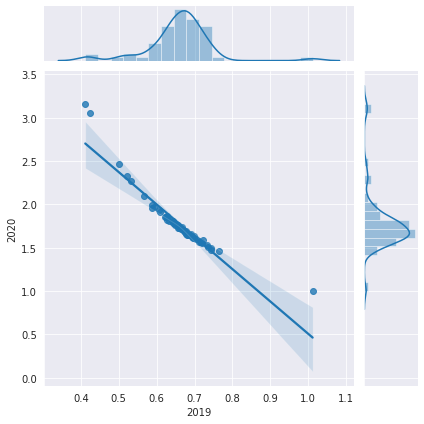

In [435]:
mettemp=met.copy()
mettemp=mettemp.drop(36)
mettemp=mettemp.drop(52)
mettemp=mettemp.drop(63)
sns.jointplot(mettemp["2019"],mettemp["2020"],kind="reg");
plt.savefig("dif1819.png",format="png")

In [426]:
# ordeno por cada ventana temporal
met=mettemp.copy()
met.sort_values("2019")

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
5,0.411550,3.156404,1.299017,4.069257,4.254849
33,0.423478,3.059257,1.295527,3.931777,4.161166
1,0.500115,2.464779,1.232674,3.018599,3.162753
32,0.522172,2.333387,1.218429,2.825345,2.961506
3,0.532763,2.272522,1.210716,2.734834,2.860808
58,0.565812,2.102751,1.189762,2.487929,2.596363
44,0.586804,1.995552,1.170998,2.325966,2.393517
30,0.587201,1.961906,1.152033,2.253922,2.232546
59,0.593856,1.969148,1.169390,2.291703,2.368827


In [427]:
met.sort_values("2020")

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
47,1.011518,1.003137,1.014691,1.015864,1.059304
20,0.763292,1.467168,1.119877,1.632907,1.792142
42,0.743128,1.470940,1.093096,1.603524,1.633525
15,0.743407,1.497100,1.112955,1.658223,1.763113
57,0.734789,1.504529,1.105511,1.657082,1.721154
43,0.732613,1.534326,1.124068,1.715096,1.849356
21,0.719061,1.558061,1.120341,1.737346,1.836407
26,0.712015,1.561168,1.111575,1.729192,1.782784
27,0.715876,1.564008,1.119636,1.743204,1.834590


In [428]:
met.sort_values("2019-2020")

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
47,1.011518,1.003137,1.014691,1.015864,1.059304
42,0.743128,1.470940,1.093096,1.603524,1.633525
57,0.734789,1.504529,1.105511,1.657082,1.721154
26,0.712015,1.561168,1.111575,1.729192,1.782784
15,0.743407,1.497100,1.112955,1.658223,1.763113
27,0.715876,1.564008,1.119636,1.743204,1.834590
20,0.763292,1.467168,1.119877,1.632907,1.792142
21,0.719061,1.558061,1.120341,1.737346,1.836407
12,0.680138,1.647387,1.120450,1.839718,1.876353


In [429]:
met.sort_values("2018-2023") 

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
47,1.011518,1.003137,1.014691,1.015864,1.059304
42,0.743128,1.470940,1.093096,1.603524,1.633525
57,0.734789,1.504529,1.105511,1.657082,1.721154
15,0.743407,1.497100,1.112955,1.658223,1.763113
26,0.712015,1.561168,1.111575,1.729192,1.782784
20,0.763292,1.467168,1.119877,1.632907,1.792142
27,0.715876,1.564008,1.119636,1.743204,1.834590
21,0.719061,1.558061,1.120341,1.737346,1.836407
46,0.716366,1.564359,1.120653,1.744965,1.841201


In [430]:
met.sort_values("2019-2023") 

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
47,1.011518,1.003137,1.014691,1.015864,1.059304
42,0.743128,1.470940,1.093096,1.603524,1.633525
20,0.763292,1.467168,1.119877,1.632907,1.792142
57,0.734789,1.504529,1.105511,1.657082,1.721154
15,0.743407,1.497100,1.112955,1.658223,1.763113
43,0.732613,1.534326,1.124068,1.715096,1.849356
26,0.712015,1.561168,1.111575,1.729192,1.782784
21,0.719061,1.558061,1.120341,1.737346,1.836407
27,0.715876,1.564008,1.119636,1.743204,1.834590


In [436]:
met.sort_values("2019-2023")[:10] 

,2019,2020,2019-2020,2019-2023,2018-2023
ind,,,,,
47,1.011518,1.003137,1.014691,1.015864,1.059304
42,0.743128,1.470940,1.093096,1.603524,1.633525
20,0.763292,1.467168,1.119877,1.632907,1.792142
57,0.734789,1.504529,1.105511,1.657082,1.721154
15,0.743407,1.497100,1.112955,1.658223,1.763113
43,0.732613,1.534326,1.124068,1.715096,1.849356
26,0.712015,1.561168,1.111575,1.729192,1.782784
21,0.719061,1.558061,1.120341,1.737346,1.836407
27,0.715876,1.564008,1.119636,1.743204,1.834590


Tiene mucho sentido los resultados (suponiendo una caída de estos). Voy a comparar, deshaciendo el logaritmo, al sector de la metalurgia y el de los alimentos.

In [0]:
seriealim=pred[5]
seriemetal=pred[15]
serietur=pred[52]
seriehost=pred[36]

In [0]:
#valores iniciales
r0al=real_vadd_ind["1998"][5]
r0me=real_vadd_ind["1998"][15]
r0tu=real_vadd_ind["1998"][52]
r0ho=real_vadd_ind["1998"][36]

In [0]:
data_515=seriealim.to_frame()
data_515[15]=seriemetal
data_515[52]=serietur
data_515[36]=seriehost
data_515.columns=["d_ln_alim","d_ln_met","d_ln_tur","d_ln_hos"]

In [0]:
data_515["alim"]=np.zeros(len(data_515))
data_515["met"]=np.zeros(len(data_515))
data_515["tur"]=np.zeros(len(data_515))
data_515["host"]=np.zeros(len(data_515))
data_515["met"][1998]=r0me
data_515["alim"][1998]=r0al
data_515["tur"][1998]=r0tu
data_515["host"][1998]=r0ho

In [0]:
for year in data_515.index[1:]:
  data_515["alim"][year]=mt.exp(data_515["d_ln_alim"][year]+mt.log(data_515["alim"][year-1]))
  data_515["met"][year]=mt.exp(data_515["d_ln_met"][year]+mt.log(data_515["met"][year-1]))
  data_515["tur"][year]=mt.exp(data_515["d_ln_tur"][year]+mt.log(data_515["tur"][year-1]))
  data_515["host"][year]=mt.exp(data_515["d_ln_hos"][year]+mt.log(data_515["host"][year-1]))

In [369]:
real_vadd_ind # coincide! :)

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
indicetio,,,,,,,,,,,,,,,,,,,,,,,
1,3.025121e+06,2.802224e+06,2.713798e+06,2.429957e+06,2.533580e+06,2326896.780,2.273054e+06,2.222393e+06,1.976936e+06,2205024.822,2.080166e+06,1.785820e+06,1.809874e+06,1.814410e+06,1.804554e+06,1.675018e+06,1.644948e+06,1.508031e+06,1.338291e+06,1.361911e+06,1337015.668,1.273758e+06,1.031497e+06
2,1.005846e+05,9.357537e+04,9.679992e+04,9.761899e+04,1.085672e+05,98548.502,1.075515e+05,9.093126e+04,8.769895e+04,137247.201,1.566053e+05,1.452132e+05,1.321349e+05,1.200238e+05,1.155391e+05,1.122569e+05,1.020669e+05,1.024408e+05,8.129776e+04,7.582473e+04,64575.212,5.629981e+04,5.060077e+04
3,1.650801e+05,1.530529e+05,1.369999e+05,1.456116e+05,1.270930e+05,128997.726,1.219248e+05,1.040009e+05,1.010192e+05,89770.590,1.061407e+05,9.868125e+04,1.007916e+05,1.079454e+05,1.018037e+05,1.067527e+05,1.086171e+05,1.061196e+05,1.070767e+05,1.011663e+05,98003.960,9.711218e+04,8.760339e+04
4,2.071336e+05,1.427848e+05,1.482999e+05,1.659319e+05,1.897080e+05,235775.748,2.564385e+05,2.446153e+05,2.310925e+05,302073.408,2.934937e+05,2.590697e+05,2.271193e+05,2.183217e+05,1.967029e+05,1.770763e+05,1.599384e+05,1.248674e+05,1.146627e+05,1.140372e+05,122639.202,1.443721e+05,1.561825e+05
5,2.654120e+06,2.426082e+06,2.449598e+06,2.482239e+06,2.522816e+06,2554134.401,2.517697e+06,2.275228e+06,2.160559e+06,2259535.005,2.020321e+06,1.772741e+06,1.631202e+06,1.397593e+06,1.280772e+06,1.165879e+06,1.099919e+06,1.026106e+06,9.702025e+05,9.152985e+05,897206.116,8.553981e+05,8.214453e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1.012114e+06,9.399191e+05,8.762993e+05,8.176101e+05,7.800487e+05,728106.782,6.741548e+05,5.924899e+05,5.357592e+05,516597.354,4.371572e+05,3.767830e+05,3.236947e+05,2.762066e+05,2.391578e+05,2.165473e+05,1.921853e+05,1.702866e+05,1.504445e+05,1.381117e+05,131231.330,1.217724e+05,1.127730e+05
61,1.258572e+05,1.223454e+05,1.283999e+05,1.298864e+05,1.330957e+05,120048.123,1.086419e+05,9.853204e+04,1.079028e+05,109575.648,9.458854e+04,8.602121e+04,7.597160e+04,6.867183e+04,6.368238e+04,6.112572e+04,5.520828e+04,4.846130e+04,4.162231e+04,3.667863e+04,33697.252,3.090840e+04,2.817691e+04
62,8.951527e+05,8.120521e+05,8.369993e+05,8.091348e+05,8.284848e+05,861630.744,8.184820e+05,7.379243e+05,6.881820e+05,702061.542,6.095706e+05,5.475677e+05,5.003784e+05,4.528239e+05,4.246226e+05,4.036904e+05,3.907047e+05,3.775029e+05,3.464721e+05,3.329753e+05,321667.792,3.130057e+05,3.021663e+05


In [370]:
data_515.head() # ya tenemos los valores, voy a ponerlos en indice 2005

,d_ln_alim,d_ln_met,d_ln_tur,d_ln_hos,alim,met,tur,host
1998,0.019965,0.086078,0.034168,0.071057,9.152985e+05,316636.602349,122039.802506,2.419656e+06
1999,0.058255,0.136981,0.039959,0.098756,9.702025e+05,363121.044750,127015.163000,2.670809e+06
2000,0.056022,0.245204,0.058752,0.146885,1.026106e+06,464025.746939,134701.177340,3.093387e+06
2001,0.069465,0.049238,0.076915,0.061545,1.099919e+06,487445.174000,145470.569500,3.289751e+06
2002,0.058239,-0.026414,0.092836,0.061855,1.165879e+06,474738.227478,159622.128659,3.499664e+06


In [0]:
indice2007alim=100*data_515["alim"]/data_515["alim"][2007]
indice2007met=100*data_515["met"]/data_515["met"][2007]
indice2007tur=100*data_515["tur"]/data_515["tur"][2007]
indice2007host=100*data_515["host"]/data_515["host"][2007]
data_515["alim2007"]=indice2007alim
data_515["met2007"]=indice2007met
data_515["tur2007"]=indice2007tur
data_515["host2007"]=indice2007host

In [372]:
data_515.head()

,d_ln_alim,d_ln_met,d_ln_tur,d_ln_hos,alim,met,tur,host,alim2007,met2007,tur2007,host2007
1998,0.019965,0.086078,0.034168,0.071057,9.152985e+05,316636.602349,122039.802506,2.419656e+06,45.304609,55.359821,45.019127,47.736435
1999,0.058255,0.136981,0.039959,0.098756,9.702025e+05,363121.044750,127015.163000,2.670809e+06,48.022197,63.487026,46.854482,52.691343
2000,0.056022,0.245204,0.058752,0.146885,1.026106e+06,464025.746939,134701.177340,3.093387e+06,50.789258,81.128910,49.689767,61.028212
2001,0.069465,0.049238,0.076915,0.061545,1.099919e+06,487445.174000,145470.569500,3.289751e+06,54.442772,85.223494,53.662477,64.902200
2002,0.058239,-0.026414,0.092836,0.061855,1.165879e+06,474738.227478,159622.128659,3.499664e+06,57.707607,83.001849,58.882830,69.043499


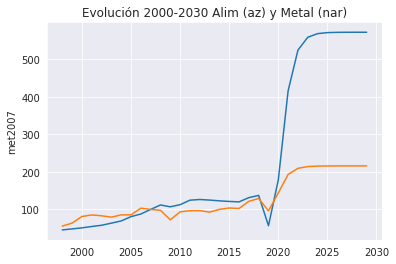

In [373]:
sns.lineplot(range(1998,2030),data_515["alim2007"]);
sns.lineplot(range(1998,2030),data_515["met2007"]);
plt.title("Evolución 2000-2030 Alim (az) y Metal (nar)");
plt.savefig("alim_met.eps",format="eps")

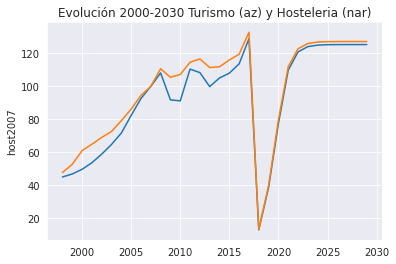

In [374]:
sns.lineplot(range(1998,2030),data_515["tur2007"]);
sns.lineplot(range(1998,2030),data_515["host2007"]);
plt.title("Evolución 2000-2030 Turismo (az) y Hosteleria (nar)");
plt.savefig("tur_hos_2030.eps",format="eps")